#Initial attempt at stats modeling and ml modeling
Note: This section focuses on trying to understand how our features relate.

- the data sets used in this section are:
    - npri_ext_fe_v3.csv (year-emission-province-sector); not energy values are national not provincial - this was an error that was overlook; although we can still use the other features if we used a national aggregation
    - npri_ext_fe_v4.csv (removes dummy variables for sector and province)
    - npri_ext_fe_v5.csv (new data set for provinicial not national energy encorporated)



##Attempt 1: Stats modelling rolling windows


###Minimal features, across all sectors and provinces

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('npri_ext_fe_v3.csv')

In [ ]:
df.columns

Index(['Unnamed: 0', 'year', 'co_emissions', 'no_emissions', 'gdp', 'yoy_gdp',
       'pop', 'yoy_pop', 'net_energy_per_sector', 'canada_gdp',
       'canada_yoy_gdp', 'sector_net_energy_per_canadian_gdp',
       'canada_energy_per_capita', 'canada_pop', 'canada_yoy_pop',
       'no_per_gdp', 'co_per_gdp', 'no_per_capita', 'co_per_capita',
       'carbon_policy', 'carbon_price', 'high_emitters',
       'price_x_high_emitters', 'yoy_co', 'yoy_no', 'log_nitrogen_oxides',
       'log_carbon_monoxide', 'log_no_per_gdp', 'log_co_per_gdp',
       'distrupting_event_yr', 'carbon', 'nitrogen', 'ab', 'bc', 'mb', 'nb',
       'nl', 'ns', 'nt', 'nu', 'on', 'pe', 'qc', 'sk', 'yt',
       'agriculture,_forestry,_fishing,_hunting', 'construction',
       'manufacturing_and_industrial', 'mining,_oil_and_gas,_energy',
       'public_admin', 'transportation'],
      dtype='object')

The current grain of the feature engineered data frame is year-substance-sector-province

We will begin by following the approach in phase 1 of our project: Rolling Window Forecast.

We will model per sector because the sectors are producing emissions at different rates, some are producing majority of the emissions such as the oil and gas, manufacturing sectors as shown in the EDA master colab file section P2 : 3. This means that we can focus on sector specific emissions to see changes and predict.

To being we will include features such as
- 'carbon_price'
- 'carbon_policy'
- 'gdp'
- 'pop'
- 'net_energy_per_sector'

We will first do some diagnostics to see what how are coefficients are changing over time. This will help us to remove unstable/useless features (ie. if we see that a feature has no change over time).

We will then use rolling window forecast to predict future values, using the values of the coefficients we found in the earlier step.

Note:
We will first attempt to do some statsmodeling as a method to understand our feature correlation.
We are using statsmodels library specifically sm.OLS and not RollingOLS as the later would work for rows that were years which is not the case for us. Each row represents a year-sector-province thus we needed custom logic.


In [ ]:
import statsmodels.api as sm


# Create a new df for rolling window forecast
df_rwf = df.copy()


# Define base features that all sector models will use
base_features = [
    'carbon_price',
    'carbon_policy',
    'gdp',
    'pop',
    'net_energy_per_sector'
]


# Define the sectors
sector_dummies = [
    'construction',
    'manufacturing_and_industrial',
    'mining,_oil_and_gas,_energy',
    'public_admin',
    'transportation',
    'agriculture,_forestry,_fishing,_hunting'
]


# Create function for rolling forecast by sector
# Window size of 4 years as in phase 1 of project
def rolling_forecast_sector(df, sector_col, target_col, features, window=4):
  """
  sector_col = column name from sector dummy we are filtering on
  target_col = dependant variable
  features = list of predictors
  window = number of years we are training on before forecasting next year (4 years as in phase 1 project report)
  """

  # filter sector
  sec_df = df[df[sector_col] ==1].copy()

  # Sort by year
  sec_df = sec_df.sort_values(['year'])
  # Define years variable
  years = sorted(sec_df['year'].unique())

  # Some sectors have features with constant values ()

  # List to store window's performance and coeff.
  results = []

  for i in range(len(years) - window):
    # Define the train/test years
    train_years = years[i:i+window]
    test_year = years[i+window]

    # Create train/test dfs
    train_df = sec_df[sec_df['year'].isin(train_years)]
    test_df = sec_df[sec_df['year'] == test_year]

    # Check if we have enough rows to fit a model
    if len(train_df) < len(features) + 2:
      continue

    # Define features
    X_train = sm.add_constant(train_df[features])
    y_train = train_df[target_col]

    model = sm.OLS(y_train, X_train).fit()

    # Evaluation R2
    train_r2 = model.rsquared

    # Test prediction
    if len(test_df) > 0:
      X_test = sm.add_constant(test_df[features], has_constant='add')
      y_test = test_df[target_col]
      y_pred = model.predict(X_test)

      #Mean-Squared-Error
      mse = np.mean((y_test-y_pred)**2)
      mae = np.mean(np.abs(y_test-y_pred))
    else:
      mse = np.nan
      mae = np.nan

    # Store results
    results.append({
        'sector':sector_col,
        'target':target_col,
        'train_start_year':train_years[0],
        'train_end_year':train_years[-1],
        'test_year':test_year,
        'train_len':len(train_df),
        'test_len':len(test_df),
        'train_r2':train_r2,
        'test_mse':mse,
        'test_mae':mae,
        'features':features,
        **{f"beta_{col}":model.params.get(col,np.nan) for col in features}
    })

  return pd.DataFrame(results)


In [ ]:
# Run for first target: log_carbon_monoxide

# List to store results
results_log_co = []

# iterate through the sectors
for sec in sector_dummies:
  res = rolling_forecast_sector(
      df = df_rwf,
      sector_col = sec,
      target_col = 'log_carbon_monoxide',
      features= base_features,
      window=4
  )

  # Append all results
  results_log_co.append(res)

results_log_co = pd.concat(results_log_co, ignore_index=True)


In [ ]:
results_log_co.head()

,sector,target,train_start_year,train_end_year,test_year,train_len,test_len,train_r2,test_mse,test_mae,features,beta_carbon_price,beta_carbon_policy,beta_gdp,beta_pop,beta_net_energy_per_sector
0,construction,log_carbon_monoxide,2012,2015,2016,7,2,0.976549,0.762516,0.813273,"[carbon_price, carbon_policy, gdp, pop, net_en...",-2.667315e-08,-7.184927e-11,-0.000052,-2.229071e-08,0.000019
1,construction,log_carbon_monoxide,2013,2016,2017,8,2,0.757985,0.013341,0.112852,"[carbon_price, carbon_policy, gdp, pop, net_en...",1.058342e-08,-9.393902e-11,-0.000014,-4.660811e-08,0.000001
2,construction,log_carbon_monoxide,2014,2017,2018,8,1,0.796070,0.028105,0.167645,"[carbon_price, carbon_policy, gdp, pop, net_en...",-9.873849e-09,-1.200700e-10,-0.000011,-5.103516e-08,-0.000002
3,construction,log_carbon_monoxide,2015,2018,2019,7,1,0.942473,0.009955,0.099777,"[carbon_price, carbon_policy, gdp, pop, net_en...",-1.489561e-08,-4.534014e-12,0.000017,-1.181249e-07,-0.000010
4,manufacturing_and_industrial,log_carbon_monoxide,2002,2005,2006,40,10,0.502991,3.582633,1.518282,"[carbon_price, carbon_policy, gdp, pop, net_en...",1.922527e-10,-3.879317e-09,-0.000038,1.542329e-06,0.000001


Visuals
- rolling coeffecient paths
  - examines how the effect of carbon price/GDP/policy change over time


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = results_log_co.copy()


In [ ]:
df_viz.dtypes

,0
sector,object
target,object
train_start_year,int64
train_end_year,int64
test_year,int64
train_len,int64
test_len,int64
train_r2,float64
test_mse,float64
test_mae,float64


In [ ]:
df_viz = df_viz.sort_values(['sector','target','test_year'])

In [ ]:
from matplotlib.lines import lineStyles
# Plot for rolling coeff paths (ie. beta values)

def coeff_viz(df_viz, target, sector, feature):
  # Select one target and sector
  subset = df_viz[(df_viz['target'] == target) & (df_viz['sector'] == sector)].copy()

  # Check
  if subset.empty:
    print(f"No data for {sector} / {target}")
    return

  # Plot
  plt.figure(figsize=(9,5))
  plt.plot(subset['test_year'], subset[feature], marker='o')

  plt.axhline(0, color='black', linestyle='--')
  plt.title(f"Rolling Coeffecient Path:\n{feature} -> {target} ({sector})")
  plt.xlabel("Test Year")
  plt.ylabel("Coefficient Value")
  plt.grid(True)
  plt.show()


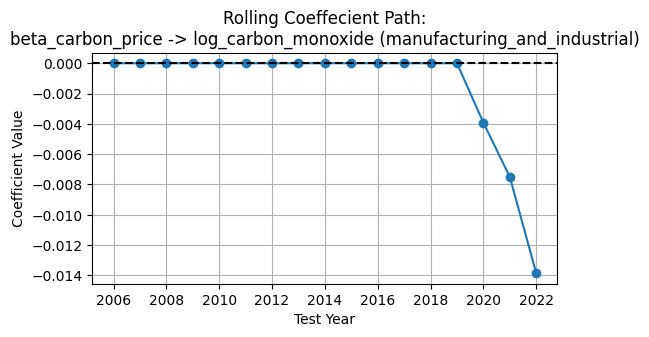

In [ ]:
# Plot for log carbon as target
coeff_viz(df_viz,
          target='log_carbon_monoxide',
          sector='manufacturing_and_industrial',
          feature='beta_carbon_price')



This graph makes sense as carbon policy did not start till 2019

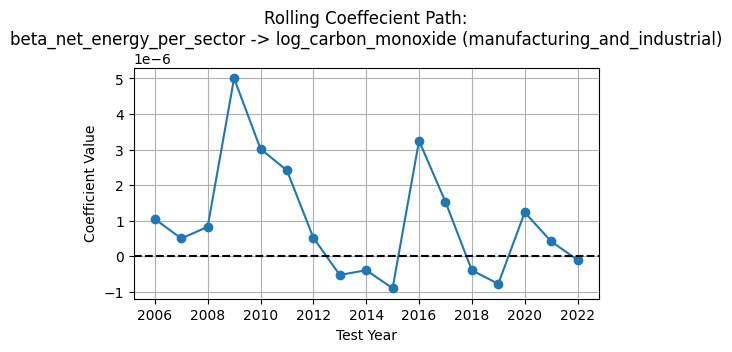

In [ ]:
# Plot for log carbon as target
coeff_viz(df_viz,
          target='log_carbon_monoxide',
          sector='manufacturing_and_industrial',
          feature='beta_net_energy_per_sector')

This graph shows us that the coefficient values have variation. The positive peaks (2009, 2016; beta roughly equals 5e-6 and 3e-6) indicate that in these windows higher sector energy usage is associateed with higher CO emissions. The negative dips are associated with lower  CO emissions

The values tell us that a 1 unit increase in net energy per sector increases log(co emissions) by x amount.

Note: the coefficient is incredibly small

Test if above works or not - then move to create data frame for all targets.

It works - shows us variations in the coeff.

In [ ]:
# Start off wit these targets
# Can potentially add more:
targets = [
    'log_carbon_monoxide',
    'log_nitrogen_oxides',
    'log_co_per_gdp',
    'log_no_per_gdp'
]

all_roll_win_res = []

for target in targets:
  # iterate through the sectors
  for sec in sector_dummies:
    res = rolling_forecast_sector(
        df = df_rwf,
        sector_col = sec,
        target_col = target,
        features= base_features,
        window=4
    )

    # Append all results
    all_roll_win_res.append(res)


all_roll_win_res = pd.concat(all_roll_win_res, ignore_index=True)


Now lets examine some graphs.

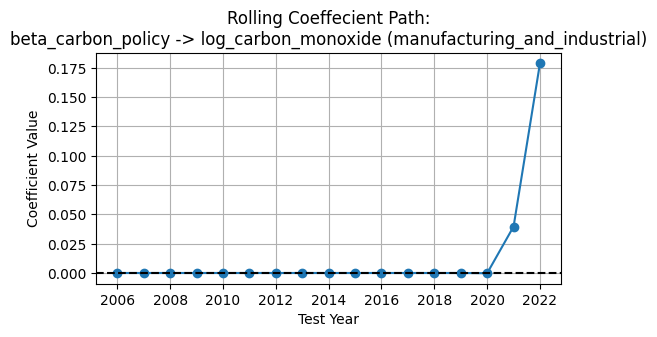

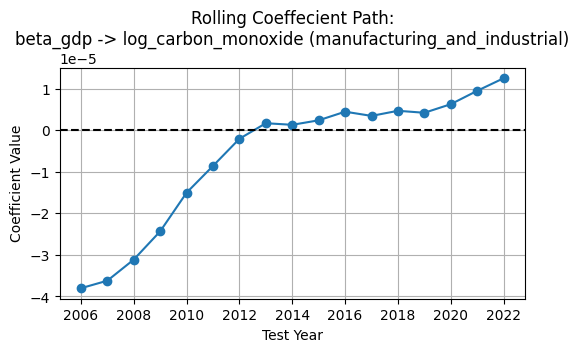

In [ ]:
# Plot for log carbon as target
coeff_viz(all_roll_win_res,
          target='log_carbon_monoxide',
          sector='manufacturing_and_industrial',
          feature='beta_carbon_policy')
print("\n\n")
coeff_viz(all_roll_win_res,
          target='log_carbon_monoxide',
          sector='manufacturing_and_industrial',
          feature='beta_gdp')
print("\n\n")



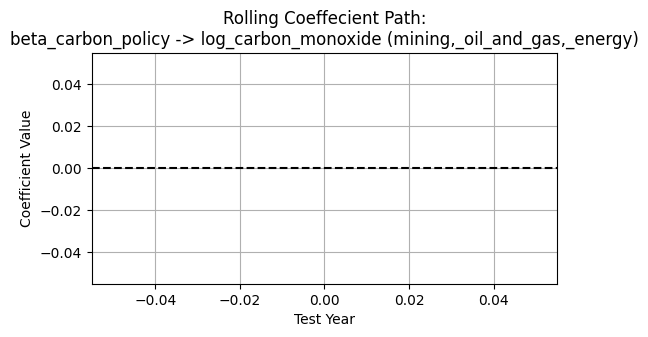

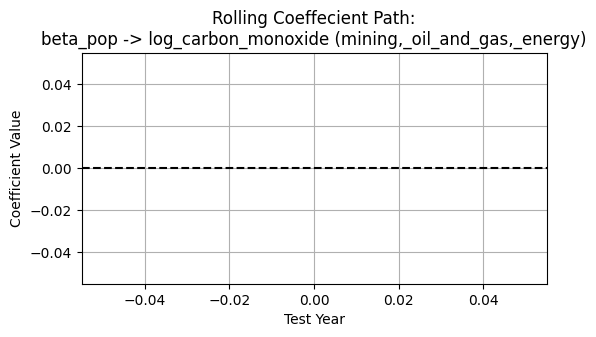

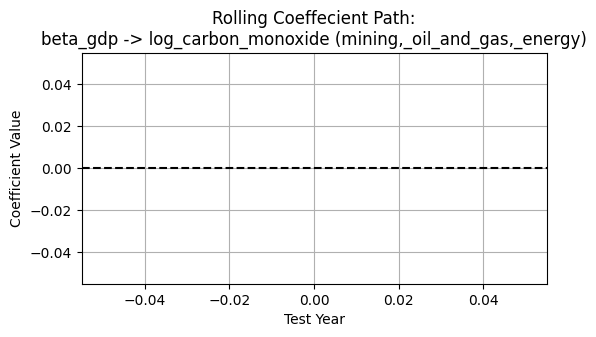

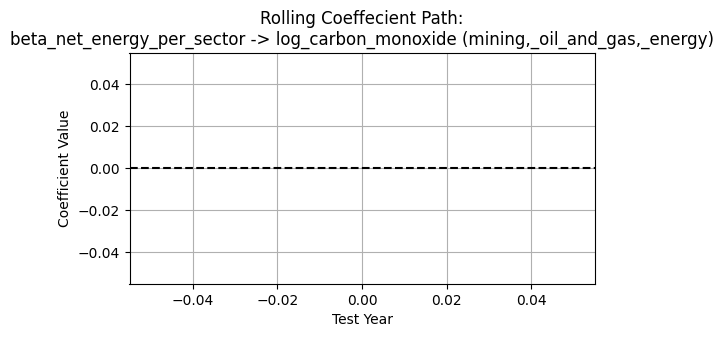

In [ ]:
coeff_viz(all_roll_win_res,
          target='log_carbon_monoxide',
          sector='mining,_oil_and_gas,_energy',
          feature='beta_carbon_policy')
print("\n\n")
coeff_viz(all_roll_win_res,
          target='log_carbon_monoxide',
          sector='mining,_oil_and_gas,_energy',
          feature='beta_pop')
print("\n\n")
coeff_viz(all_roll_win_res,
          target='log_carbon_monoxide',
          sector='mining,_oil_and_gas,_energy',
          feature='beta_gdp')
print("\n\n")
coeff_viz(all_roll_win_res,
          target='log_carbon_monoxide',
          sector='mining,_oil_and_gas,_energy',
          feature='beta_net_energy_per_sector')


No variations in coeff. for carbon policy and carbon emissions in the mining, energy sector- the values are all Nan which is thorowing off the years axis. This means that carbon policy is not the best feature showing stable behaviours as this industry has massive swings that drown out the small carbon pricing effect.

There is a slight spike for nitrogen however - Covid?


Lets try to model this for a nationally aggregated data set instread to see if we can see changes

###Aggregate nationally and view per sector

Now lets do the same as above but with a nationally aggregated data set that can be examined per sectorr


In [ ]:
df_national = pd.read_csv('npri_ext_fe_v4.csv')

In [ ]:
df_national.columns

Index(['Unnamed: 0', 'year', 'province', 'sector_category', 'co_emissions',
       'no_emissions', 'gdp', 'yoy_gdp', 'pop', 'yoy_pop',
       'net_energy_per_sector', 'canada_gdp', 'canada_yoy_gdp',
       'sector_net_energy_per_canadian_gdp', 'canada_energy_per_capita',
       'canada_pop', 'canada_yoy_pop', 'no_per_gdp', 'co_per_gdp',
       'no_per_capita', 'co_per_capita', 'carbon_policy', 'carbon_price',
       'high_emitters', 'price_x_high_emitters', 'yoy_co', 'yoy_no',
       'log_nitrogen_oxides', 'log_carbon_monoxide', 'log_no_per_gdp',
       'log_co_per_gdp', 'distrupting_event_yr', 'carbon', 'nitrogen'],
      dtype='object')

In [ ]:
# CREATE NATIONAL-LEVEL AGGREGATED DATAFRAME
# year - sector_category

# Drop the province column because we are aggregating nationally
df_clean = df_national.drop(columns=['province'], errors='ignore')

df_national_agg = (
    df_clean
    .groupby(['year', 'sector_category'], as_index=False)
    .agg({

        # Emissions → sum across provinces
        'co_emissions': 'sum',
        'no_emissions': 'sum',

        # Provincial-level values (mean across provinces)
        'gdp': 'mean',
        'yoy_gdp': 'mean',
        'pop': 'mean',
        'yoy_pop': 'mean',

        # National-level indicators → already identical across provinces
        'net_energy_per_sector': 'first',
        'canada_gdp': 'first',
        'canada_yoy_gdp': 'first',
        'sector_net_energy_per_canadian_gdp': 'first',
        'canada_energy_per_capita': 'first',
        'canada_pop': 'first',
        'canada_yoy_pop': 'first',

        # Ratios, YOYs, logs → average across provinces
        'no_per_gdp': 'mean',
        'co_per_gdp': 'mean',
        'no_per_capita': 'mean',
        'co_per_capita': 'mean',
        'yoy_co': 'mean',
        'yoy_no': 'mean',
        'log_nitrogen_oxides': 'mean',
        'log_carbon_monoxide': 'mean',
        'log_no_per_gdp': 'mean',
        'log_co_per_gdp': 'mean',

        # Policy and classification variables
        'carbon_policy': 'first',
        'carbon_price': 'first',
        'high_emitters': 'first',
        'price_x_high_emitters': 'first',

        # Event + indicator variables
        'distrupting_event_yr': 'first',
        'carbon': 'first',
        'nitrogen': 'first'
    })
)


Let's rework the model pipeline.

Note: initally started off with window of 4, but have now changed it to 8 as all the train r-sqared values were 1. They were being trained on only 4 data points (ie. years) while fitting 3 features + a constant feature (ie. n=4 -> 0 degrees of freedom since 4 data points -> perfect interpolation -> makes estimated coefficients meaningless). Now that this has been adjusted the r-sqaured values are more sensible.  

In [ ]:
def rolling_forecast_sector_nat(df, sector_name, target_col, features, window=8):
  sec_df = df[df['sector_category']==sector_name].copy()

  # Sort by year
  sec_df = sec_df.sort_values('year')

  # Extract years
  years = sorted(sec_df['year'].unique())

  results = []

  for i in range(len(years) - window):
    # Define the train/test years
    train_years = years[i:i+window]
    test_year = years[i+window]

    # Create train/test dfs
    train_df = sec_df[sec_df['year'].isin(train_years)]
    test_df = sec_df[sec_df['year'] == test_year]

    # # Check if we have enough rows to fit a model
    # if len(train_df) < len(features) + 2:
    #   continue

    # only keep features that have variation
    valid_features = [f for f in features if train_df[f].nunique() >1]
    if len(valid_features) == 0:
      continue

    # Define features
    X_train = sm.add_constant(train_df[valid_features])
    y_train = train_df[target_col]

    model = sm.OLS(y_train, X_train).fit()

    # Evaluation R2
    train_r2 = model.rsquared

    # Test prediction
    if len(test_df) > 0:
      X_test = sm.add_constant(test_df[valid_features], has_constant='add')
      y_test = test_df[target_col]
      y_pred = model.predict(X_test)

      #Mean-Squared-Error
      mse = np.mean((y_test-y_pred)**2)
      mae = np.mean(np.abs(y_test-y_pred))
    else:
      mse = np.nan
      mae = np.nan

    # Store results
    results.append({
        'sector':sector_name,
        'target':target_col,
        'train_start_year':train_years[0],
        'train_end_year':train_years[-1],
        'test_year':test_year,
        'train_len':len(train_df),
        'test_len':len(test_df),
        'train_r2':train_r2,
        'test_mse':mse,
        'test_mae':mae,
        'features':valid_features,
        **{f"beta_{col}":model.params.get(col,np.nan) for col in valid_features}
    })

  return pd.DataFrame(results)



# Define base features that all sector models will use
base_features = [
    'carbon_price',
    'carbon_policy',
    'gdp',
    'pop',
    'net_energy_per_sector'
]


# Define the sectors
sectors = df_national_agg['sector_category'].unique().tolist()

# Start off wit these targets
# Can potentially add more:
targets = [
    'log_carbon_monoxide',
    'log_nitrogen_oxides',
    'log_co_per_gdp',
    'log_no_per_gdp'
]

all_roll_win_res_nat = []

for target in targets:
  # iterate through the sectors
  for sec in sectors:
    res = rolling_forecast_sector_nat(
        df = df_national_agg,
        sector_name = sec,
        target_col = target,
        features= base_features,
        window=8
    )

    # Append all results
    all_roll_win_res_nat.append(res)


all_roll_win_res_nat = pd.concat(all_roll_win_res_nat, ignore_index=True)


In [ ]:
all_roll_win_res_nat.head()

,sector,target,train_start_year,train_end_year,test_year,train_len,test_len,train_r2,test_mse,test_mae,features,beta_gdp,beta_pop,beta_net_energy_per_sector,beta_carbon_price,beta_carbon_policy
0,"Agriculture, Forestry, Fishing, Hunting",log_carbon_monoxide,2002,2009,2010,8,1,0.693783,0.681588,0.825583,"[gdp, pop, net_energy_per_sector]",-0.000031,-8.613123e-09,0.000015,NaN,NaN
1,"Agriculture, Forestry, Fishing, Hunting",log_carbon_monoxide,2003,2010,2011,8,1,0.804423,0.532469,0.729705,"[gdp, pop, net_energy_per_sector]",-0.000010,-2.949362e-07,0.000013,NaN,NaN
2,"Agriculture, Forestry, Fishing, Hunting",log_carbon_monoxide,2004,2011,2012,8,1,0.856810,1.475562,1.214727,"[gdp, pop, net_energy_per_sector]",0.000206,-5.776971e-07,0.000009,NaN,NaN
3,"Agriculture, Forestry, Fishing, Hunting",log_carbon_monoxide,2005,2012,2013,8,1,0.720853,0.790577,0.889144,"[gdp, pop, net_energy_per_sector]",0.000196,-7.439816e-07,0.000006,NaN,NaN
4,"Agriculture, Forestry, Fishing, Hunting",log_carbon_monoxide,2006,2013,2014,8,1,0.903975,0.022996,0.151643,"[gdp, pop, net_energy_per_sector]",-0.001856,-4.795457e-07,0.000021,NaN,NaN


In [ ]:
all_roll_win_res_nat.to_csv('national2.csv')

In [ ]:
all_roll_win_res_nat['sector'].unique()

array(['Agriculture, Forestry, Fishing, Hunting', 'Construction',
       'Manufacturing and Industrial', 'Mining, Oil and Gas, Energy',
       'Public Admin', 'Transportation'], dtype=object)

Coefficients graphs across different sectorsr

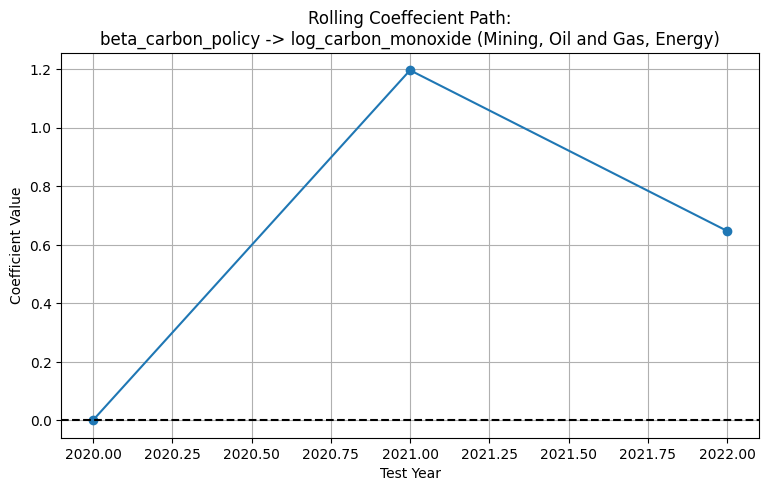

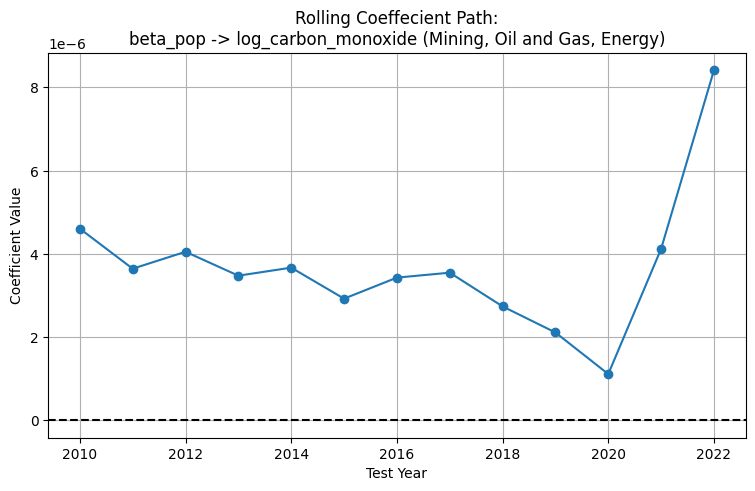

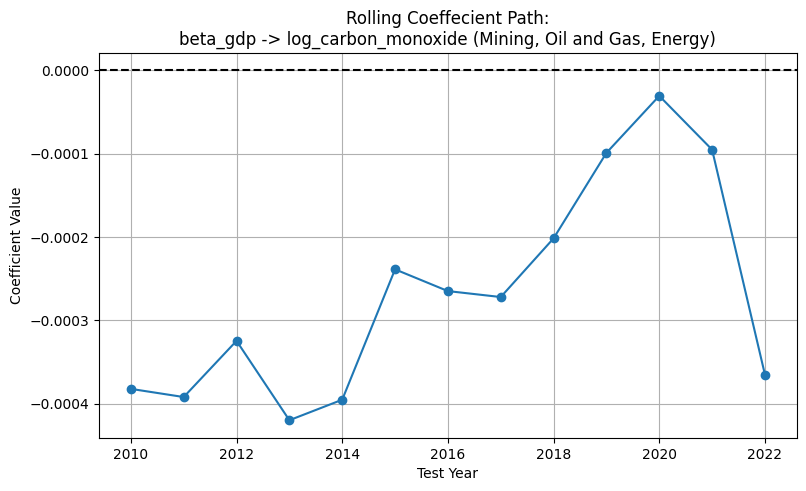

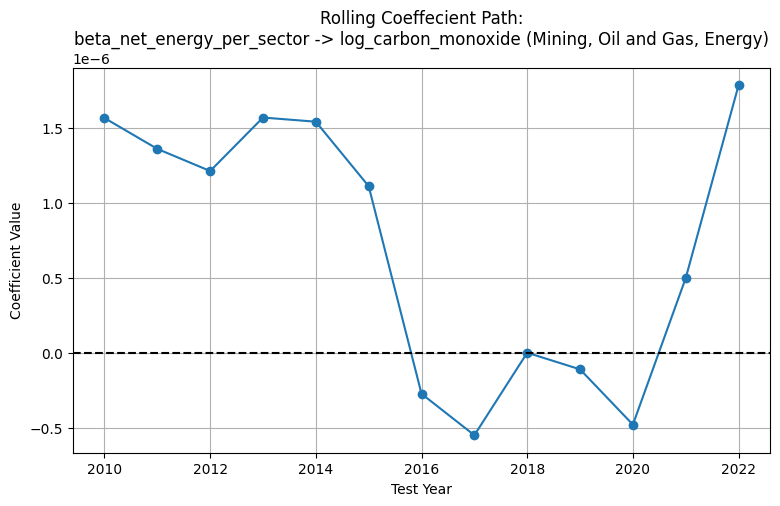

In [ ]:
coeff_viz(all_roll_win_res_nat,
          target='log_carbon_monoxide',
          sector='Mining, Oil and Gas, Energy',
          feature='beta_carbon_policy')
print("\n\n")
coeff_viz(all_roll_win_res_nat,
          target='log_carbon_monoxide',
          sector='Mining, Oil and Gas, Energy',
          feature='beta_pop')
print("\n\n")
coeff_viz(all_roll_win_res_nat,
          target='log_carbon_monoxide',
          sector='Mining, Oil and Gas, Energy',
          feature='beta_gdp')
print("\n\n")
coeff_viz(all_roll_win_res_nat,
          target='log_carbon_monoxide',
          sector='Mining, Oil and Gas, Energy',
          feature='beta_net_energy_per_sector')

carbon price plot
- years make sense as we onnly have 3 rolling windows to produce valid coeff.
  - first window contained non-zero points
- there is almost no response to carbon policy for this sector
-covid disruptions
gdp, energy
- dips during recession and covid years
pop
- pop doesn't drive industrial output

Energy is a strong driver of emissions than carbon price - makes sense.

Coefficients are small because carbon price was too low for heavy emitters

Check NO coeffcients graphs across sectors

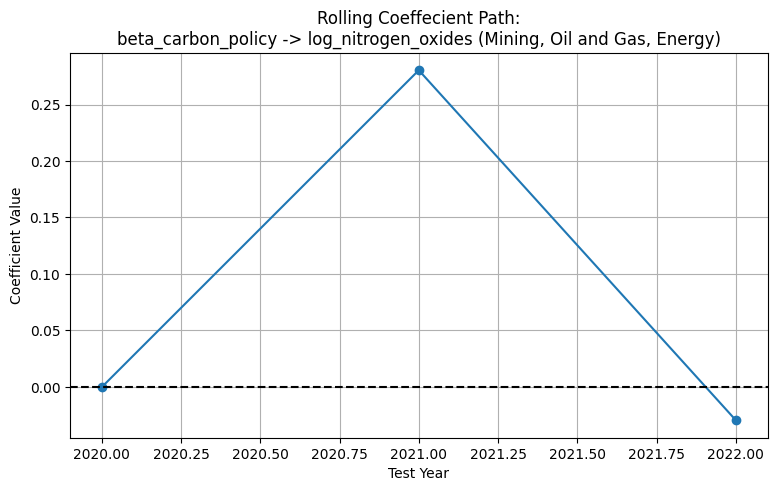

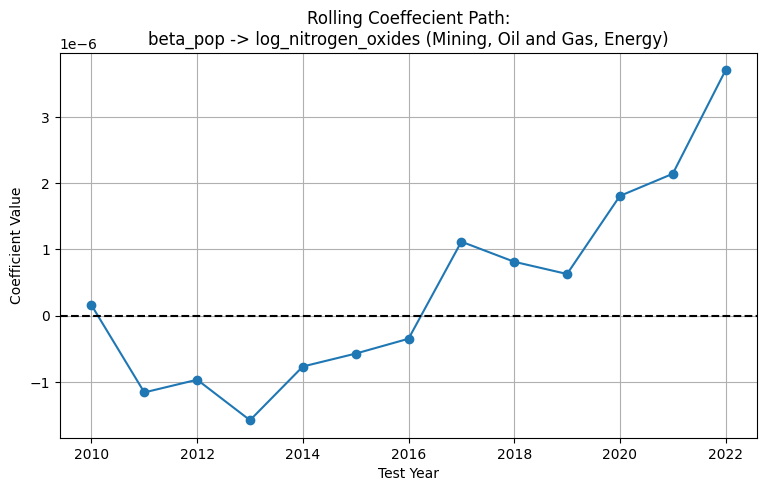

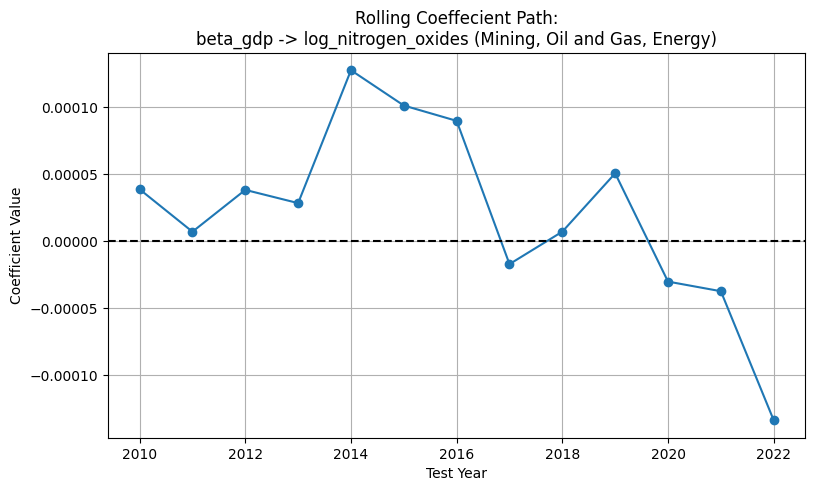

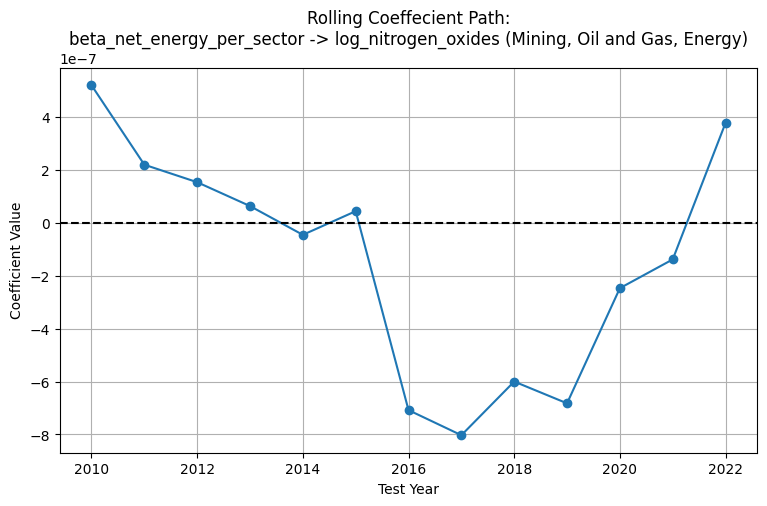

In [ ]:
coeff_viz(all_roll_win_res_nat,
          target='log_nitrogen_oxides',
          sector='Mining, Oil and Gas, Energy',
          feature='beta_carbon_policy')
print("\n\n")
coeff_viz(all_roll_win_res_nat,
          target='log_nitrogen_oxides',
          sector='Mining, Oil and Gas, Energy',
          feature='beta_pop')
print("\n\n")
coeff_viz(all_roll_win_res_nat,
          target='log_nitrogen_oxides',
          sector='Mining, Oil and Gas, Energy',
          feature='beta_gdp')
print("\n\n")
coeff_viz(all_roll_win_res_nat,
          target='log_nitrogen_oxides',
          sector='Mining, Oil and Gas, Energy',
          feature='beta_net_energy_per_sector')

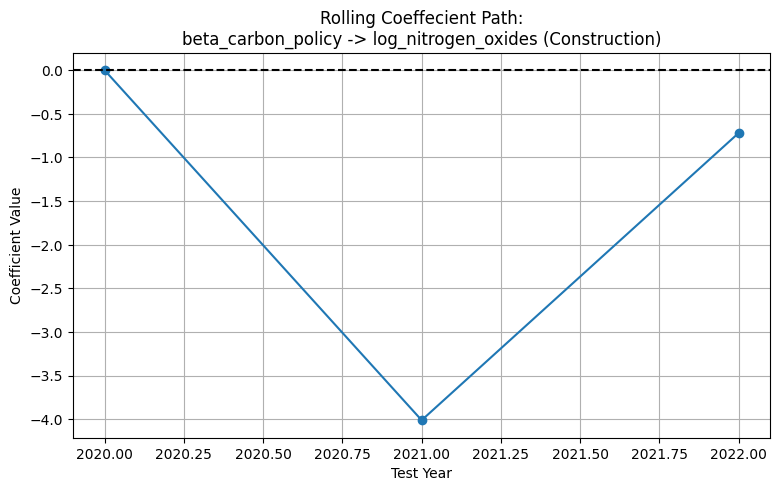

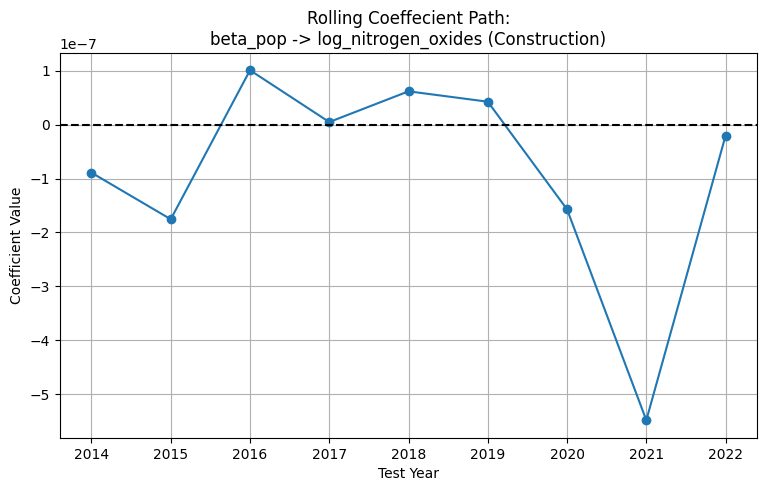

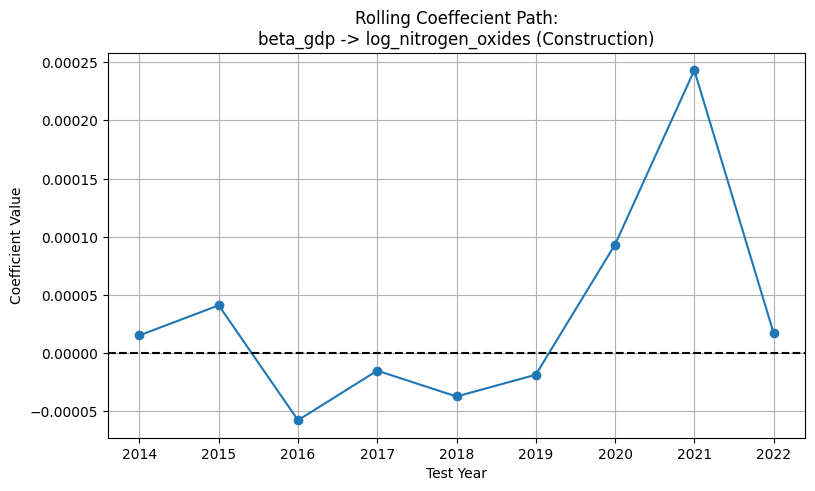

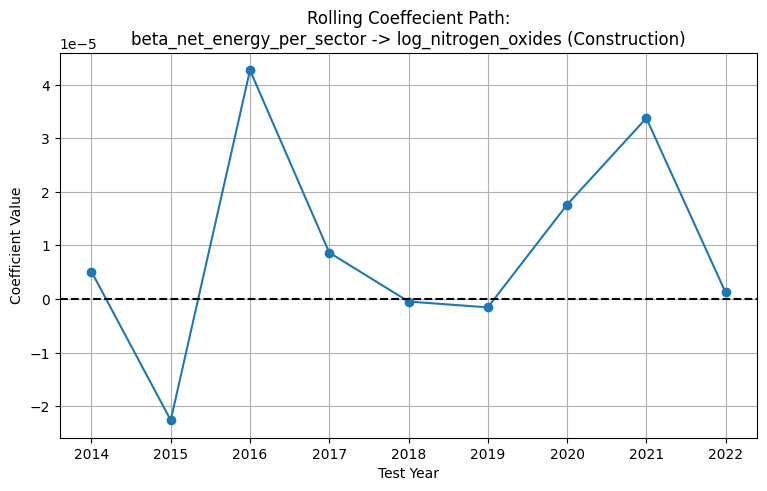

In [ ]:
coeff_viz(all_roll_win_res_nat,
          target='log_nitrogen_oxides',
          sector='Construction',
          feature='beta_carbon_policy')
print("\n\n")
coeff_viz(all_roll_win_res_nat,
          target='log_nitrogen_oxides',
          sector='Construction',
          feature='beta_pop')
print("\n\n")
coeff_viz(all_roll_win_res_nat,
          target='log_nitrogen_oxides',
          sector='Construction',
          feature='beta_gdp')
print("\n\n")
coeff_viz(all_roll_win_res_nat,
          target='log_nitrogen_oxides',
          sector='Construction',
          feature='beta_net_energy_per_sector')

The rolling regerssion behaves as expected, the coeff. are incredible small as our features are not crazy drivers of the emisssions changes. The coefficients for policy features are even further showing no impact (ie. constant straigt lines across these features for all targets). The lack of data should be taken into account here.
Features such as energy, pop, and gdp are showing coefficients with slight variation even though the numbers are still tiny.

###Forecast for natinoally aggregated sector specific rolling windows

We will be keeping gdp, pop, and energy constant to predict the impact of the carbon pricing system. Firstly because we only haave values till 2022 for these features (the next step of this project would have been to extract data on the years 2023-2025 since we have access to them), and secondly we want to isolate the impact of the carbon policy. We want to see how the log(price) has changed with respect to carbon pricing.

We will be using the beta from the last year (ie.2022) for carbon pricing to predcit for te future years. Where our formula is:

log(emissions) = b_0 + b_1X + epsilon

Keeping all other features constant we can get the changes in emissions:

change log(emissions) = b_price * delta_price

(ie. standard log-linear model; note: b = beta)

and then the % change in emissions is roughly:
exp(b_price * delta_price)-1)x100

In [ ]:
# Step 1 : define prices map
price_df = pd.DataFrame({
    'year': [2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030],
    'carbon_price': [20, 30, 40, 50, 65, 80, 95, 110, 125, 140, 155, 170]
})

# Base price nad year
base_year = 2022
base_price = price_df.loc[price_df['year'] == base_year, 'carbon_price'].iloc[0]

# Step 2: Create a helper function to compute % change from b_price
def emission_change_simulation(beta_price, price_df, base_price):
  """
  Given a carbon price coeff. from a log emissions model compute the & change
  in emissions for each future carbon price relative to the baseline price
  """

  df_sim = price_df.copy()
  df_sim['delta_price'] = df_sim['carbon_price'] - base_price

  # dela(log(emissions)) = beta * delta price
  df_sim['delta_log_emissions'] = beta_price * df_sim['delta_price']

  # % change = (exp)
  df_sim['pct_change_emissions'] = (np.exp(df_sim['delta_log_emissions']) - 1) * 100

  return df_sim



In [ ]:
# Step 3 : extract beta for each sector and emissions from the rolling results

# this table was created above when we were exploring  our coeff. graphs
# this data frame represents all of the coeff's foir each sector, target, feature, along with MSE values
rolling_df = all_roll_win_res_nat.copy()

# define our targets
targets_forecast = ['log_carbon_monoxide','log_nitrogen_oxides']

# Take the last available window (max test year) for each sector/arget
latest_betas = (
    rolling_df
    .groupby(['sector','target'])
    .apply(lambda g:g.loc[g['test_year'].idxmax()])
    .reset_index(drop=True)
)

latest_betas = latest_betas[latest_betas['target'].isin(targets_forecast)]
# inspect to see which sectors have a non-zero meaningful beta carbon price
latest_betas[['sector','target','test_year','beta_carbon_price']]





/tmp/ipython-input-2128352773.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g:g.loc[g['test_year'].idxmax()])


,sector,target,test_year,beta_carbon_price
0,"Agriculture, Forestry, Fishing, Hunting",log_carbon_monoxide,2022,0.000335
2,"Agriculture, Forestry, Fishing, Hunting",log_nitrogen_oxides,2022,-0.002914
4,Construction,log_carbon_monoxide,2022,-0.017246
6,Construction,log_nitrogen_oxides,2022,0.007239
8,Manufacturing and Industrial,log_carbon_monoxide,2022,-0.018891
10,Manufacturing and Industrial,log_nitrogen_oxides,2022,-0.013897
12,"Mining, Oil and Gas, Energy",log_carbon_monoxide,2022,-0.043251
14,"Mining, Oil and Gas, Energy",log_nitrogen_oxides,2022,-0.009430
16,Public Admin,log_carbon_monoxide,2022,0.077338
18,Public Admin,log_nitrogen_oxides,2022,0.144578


In [ ]:
# Step 5: build forecast tables for each sector and emission
forcast_results = []

for _, row in latest_betas.iterrows():
  sector = row['sector']
  target = row['target']
  beta_price = row['beta_carbon_price']

  # Skip if coeff. is nan
  if pd.isna(beta_price):
    continue

  sim = emission_change_simulation(beta_price, price_df, base_price)
  sim['sector'] = sector
  sim['target'] = target

  forcast_results.append(sim)

forecast_results = pd.concat(forcast_results, ignore_index=True)

# filter for future year
forecast_future = forecast_results[forecast_results['year'] > base_year]
forecast_future.head()


,year,carbon_price,delta_price,delta_log_emissions,pct_change_emissions,sector,target
4,2023,65,15,0.005028,0.504037,"Agriculture, Forestry, Fishing, Hunting",log_carbon_monoxide
5,2024,80,30,0.010055,1.010615,"Agriculture, Forestry, Fishing, Hunting",log_carbon_monoxide
6,2025,95,45,0.015083,1.519746,"Agriculture, Forestry, Fishing, Hunting",log_carbon_monoxide
7,2026,110,60,0.020111,2.031444,"Agriculture, Forestry, Fishing, Hunting",log_carbon_monoxide
8,2027,125,75,0.025139,2.545720,"Agriculture, Forestry, Fishing, Hunting",log_carbon_monoxide


Lets try plotting one sector

In [ ]:
import matplotlib.pyplot as plt

def plot_forecast_curve(forecast_df, sector, target):
  sub = forecast_df[(forecast_df['sector'] == sector) & (forecast_df['target'] == target)].copy()

  if sub.empty:
    print(f"No forecast data for {sector}/{target}")
    return

  plt.figure(figsize=(8,5))
  plt.plot(sub['year'], sub['pct_change_emissions'], marker='o')
  plt.axhline(0, linestyle='--', linewidth=1)
  plt.title(f"Predicted % Change in Emissions vs 2022 Baseline\n"
              f"{sector} - {target}")
  plt.xlabel("Year (Carbon Price Increasing)")
  plt.ylabel("% Change in Emissions vs 2022")
  plt.tight_layout()
  plt.show()



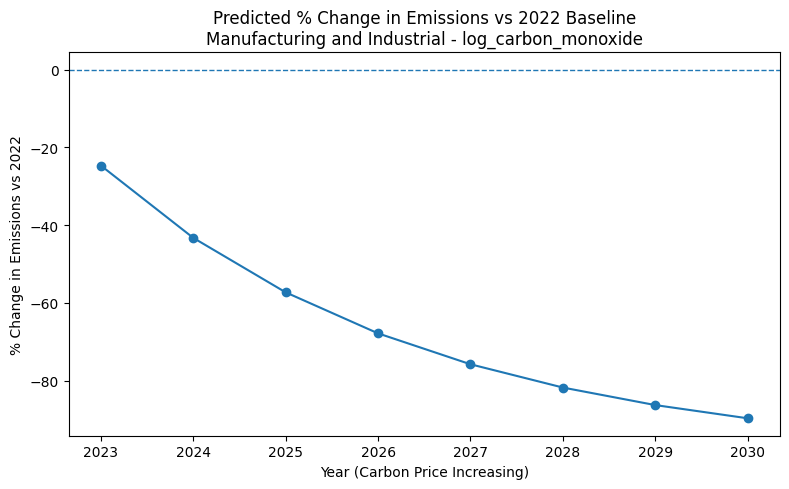

In [ ]:
# Try different sectors
plot_forecast_curve(forecast_future,
                   sector='Manufacturing and Industrial',
                   target= 'log_carbon_monoxide')

In changing the rolling window from 4-8 the graph above changed too. Note I did not show the results of the window size of 4 because this is too little data to train on - not that 8 is significantly better.

The carbon price coefficient became more negative with a window size of 8.
Canada's carbon price from 2022-2023 is increasing from $50-$170 (240% increase) so if we have a small negative beta and delta price (ie.change in price) is great, then the exponential model formulated above is going to drop drastically (ie. the graoh showing 70-90% percent decrease in the change of emisssions by 2030 - this is within mathematical reason for an exponential model).

Now lets work to build a net emissions model

In [ ]:
# Step 1: obtain baselines national emissions for 2022 and actual totals

# obtain actual totals
actual_totals = (
    df_national_agg.groupby('year')[['co_emissions','no_emissions']]
    .sum()
    .reset_index()
    )

base_co_22 = actual_totals[actual_totals['year'] ==2022]['co_emissions'].iloc[0]
base_no_22 = actual_totals[actual_totals['year'] ==2022]['no_emissions'].iloc[0]

# Step 2: convert % change to predicted emission levels
# we can use : predicted_emissions = baseline2022 * (1+ pct_change/100)
def add_emission_levels(forecast_df, baseline_2022_dict):
  df = forecast_df.copy()

  # use formula above to calc col
  df['predicted_emissions'] = df.apply(
      lambda row: baseline_2022_dict[row['target']] *
      (1+row['pct_change_emissions'] /100),
      axis=1
  )
  return df

# Define dict
baseline_2022_dict = {
    'log_carbon_monoxide':base_co_22,
    'log_nitrogen_oxides':base_no_22
}

# Calculate emissions
forecast_with_levels = add_emission_levels(forecast_future, baseline_2022_dict)

# map emission names for plotting
forecast_with_levels['emission'] = forecast_with_levels['target'].map({
    'log_carbon_monoxide':'carbon monoxide',
    'log_nitrogen_oxides':'nitrogen oxides'
})



# Step 3: plot

def plot_total_emissions_forecast(actual_df, forecast_df):
  plt.figure(figsize=(10,8))

  emissions = [
      ('carbon monoxide','co_emissions'),
      ('nitrogen oxides', 'no_emissions')
  ]

  # Plot actual emissions
  for gas_name, col in emissions:
    plt.plot(actual_df['year'],
             actual_df[col],
             marker='o',
             label=f"{gas_name} (actual)")

  # Plot forecast
  for gas_name, _ in emissions:
    df_g = forecast_df[forecast_df['emission'] == gas_name]
    plt.plot(df_g['year'],
             df_g['predicted_emissions'],
             marker='o',
             linestyle='--',
             label=f"{gas_name} (forecast)")

  plt.xlabel('Year')
  plt.ylabel('Total Emissions (tonnes)')
  plt.title("Actual & Forecasted Total Emissions (2002-2030)")
  plt.legend()
  plt.grid(True)
  plt.show()


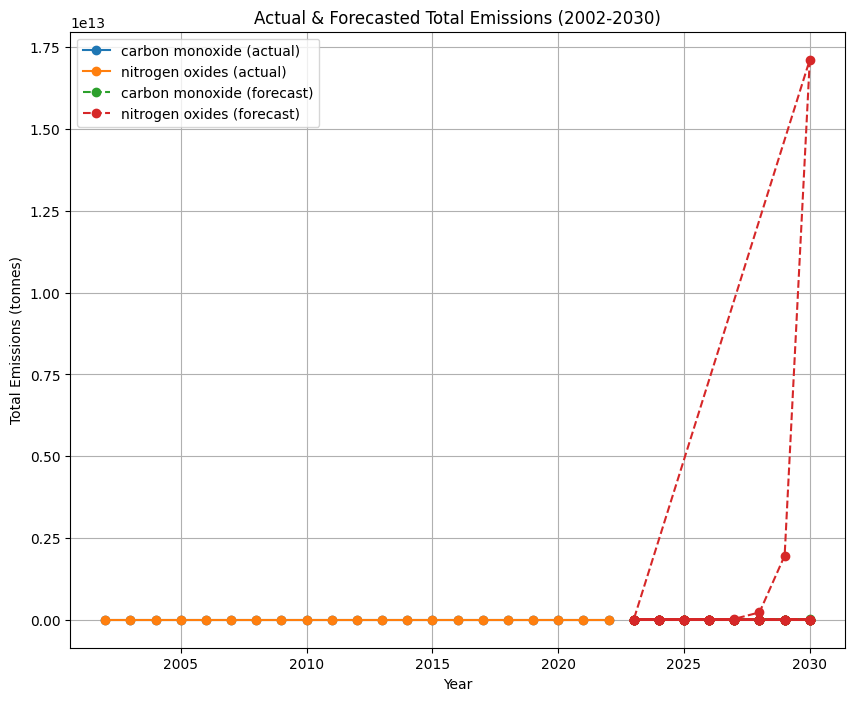

In [ ]:
# run the plot
plot_total_emissions_forecast(actual_totals,forecast_with_levels)

Based off this graph I have decided to move onto a linear regression model. The beta values are extremely noisy, tiny changes in beta lead to explosive exponential forecasts as shown by the 1e13 values of the predictions above.

##Attempt 2: Linear regression



###Aggregate nationally combine sectors on straight emissions (ie. non-normalized)

In [ ]:
# imports
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


Start off with a national model - simple approach

In [ ]:
from scipy.sparse.linalg._eigen import test
# imports
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# national - year grain
nat_year = (df_national_agg
            .groupby('year',as_index=False)
            .agg({
                'co_emissions':'sum',
                'no_emissions':'sum',

                # same across sectors in a year
                'carbon_price':'max',
                'carbon_policy':'max',

                # gdp/pop are already sector level means across prov -> take mean across sectors to get national
                'gdp':'mean',
                'pop':'mean',

                #total national energy across sectors
                'net_energy_per_sector':'sum'
            }))

# Step 2 : choose target and features
target_col = 'co_emissions'   # switch to no later

feature_cols = [
    'carbon_price',
    'carbon_policy',
    'gdp',
    'pop',
    'net_energy_per_sector',
]

# Define features
X = nat_year[feature_cols].copy()
y = nat_year[target_col].copy()
years = nat_year['year'].values



# Step 3 : split into time based train/test
# Early years for train, later years for test

split_year = 2017

train_mask = nat_year['year'] < split_year
test_mask = nat_year['year'] >= split_year

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]
years_train = years[train_mask]
years_test = years[test_mask]

# Step 4: fit
lin_model1 = LinearRegression()
lin_model1.fit(X_train, y_train)

# Coeff.
coef_table = pd.DataFrame({
    'feature':['intercept'] + feature_cols,
    'beta':[lin_model1.intercept_] + list(lin_model1.coef_)
})


# Step 5: Eval
y_train_pred = lin_model1.predict(X_train)
y_test_pred = lin_model1.predict(X_test)

# Metrics
def rmse(y_true, y_pred):
  return np.sqrt(mean_squared_error(y_true, y_pred))



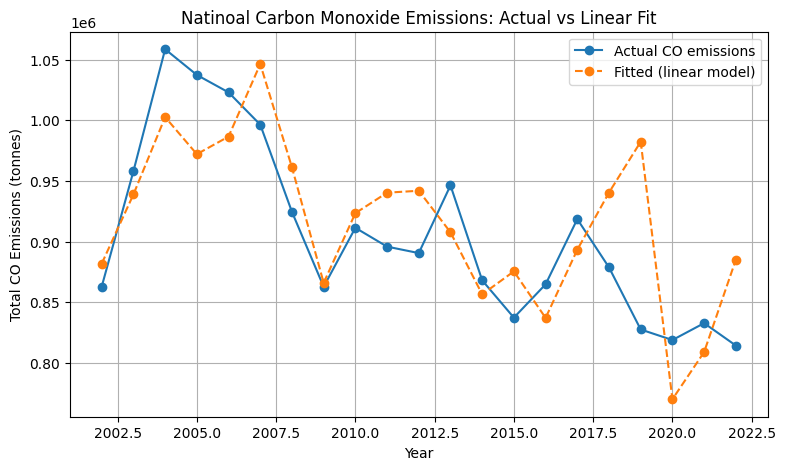

In [ ]:
# Step 6 : plot actual vs fitted
y_all_pred = lin_model1.predict(X)

plt.figure(figsize=(9,5))
plt.plot(years,
         y,
         marker='o',
         label='Actual CO emissions')
plt.plot(years,
         y_all_pred,
         marker='o',
         linestyle='--',
         label='Fitted (linear model)')

plt.xlabel('Year')
plt.ylabel('Total CO Emissions (tonnes)')
plt.title("Natinoal Carbon Monoxide Emissions: Actual vs Linear Fit")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print("Train R² :", r2_score(y_train, y_train_pred))
print("Train RMSE:", rmse(y_train, y_train_pred))
print("Test  R² :", r2_score(y_test, y_test_pred))
print("Test  RMSE:", rmse(y_test, y_test_pred))


Train R² : 0.691135683221263
Train RMSE: 38245.93123617948
Test  R² : -3.251740245398711
Test  RMSE: 77871.16505653934


A value of -3.2 for R2 is very bad - the model performs worse than just predicting the mean of the test target

Now calculate and plot the future values

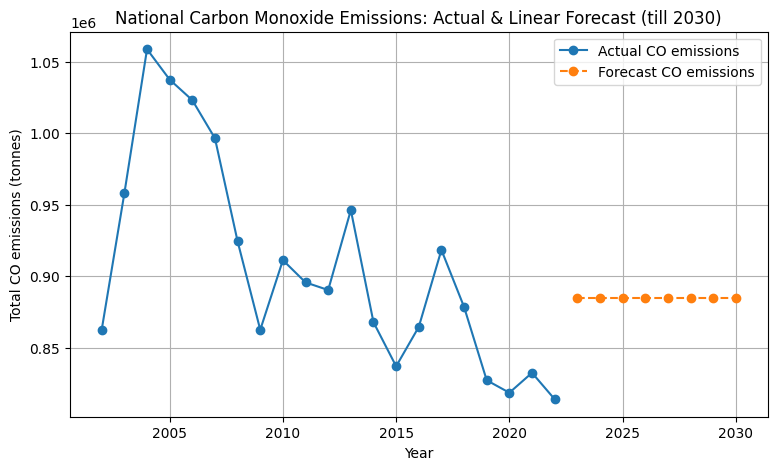

In [ ]:
# Step 1 : define prices map
price_df = pd.DataFrame({
    'year': [2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030],
    'carbon_price': [20, 30, 40, 50, 65, 80, 95, 110, 125, 140, 155, 170]
})

# Step 2 take 2022 values for other predictors
row_2022 = nat_year[nat_year['year'] == 2022].iloc[0]
gdp_2022 = row_2022['gdp']
pop_2022 = row_2022['pop']
energy_2022 = row_2022['net_energy_per_sector']
policy_2022 = row_2022['carbon_policy']

# Step 3: build future feature table
future_years = price_df[price_df['year'] > 2022].copy()

future_X = pd.DataFrame({
    'carbon_price':future_years['carbon_price'],
    'carbon_policy':policy_2022,
    'gdp':gdp_2022,
    'pop':pop_2022,
    'net_energy_per_sector':energy_2022
})

# Step 4: forecast emissions
future_y_pred = lin_model1.predict(future_X)
future_years['preducted_co_emissions'] = future_y_pred

# Step 5: plot actual emissions and forecast
plt.figure(figsize=(9,5))

# actual values
plt.plot(nat_year['year'],
         nat_year[target_col],
         marker='o',
         label='Actual CO emissions')

# Forecast
plt.plot(future_years['year'],
         future_years['preducted_co_emissions'],
         marker='o',
         linestyle='--',
         label = 'Forecast CO emissions')

plt.xlabel('Year')
plt.ylabel('Total CO emissions (tonnes)')
plt.title('National Carbon Monoxide Emissions: Actual & Linear Forecast (till 2030)')
plt.legend()
plt.grid(True)
plt.show()

Now lets do sector specific modeling for log no and then log co since the national modele is not working well at all for the non normalized emissions (based of r2 values and graph above). The values of negative r squared is telling us that the model is performing worse than if we were to take the average and the RMSE are insanely large!


Start with mining sectors

###Aggregate natinolly sector specific log emissions

In [ ]:
df_national_agg.columns

Index(['year', 'sector_category', 'co_emissions', 'no_emissions', 'gdp',
       'yoy_gdp', 'pop', 'yoy_pop', 'net_energy_per_sector', 'canada_gdp',
       'canada_yoy_gdp', 'sector_net_energy_per_canadian_gdp',
       'canada_energy_per_capita', 'canada_pop', 'canada_yoy_pop',
       'no_per_gdp', 'co_per_gdp', 'no_per_capita', 'co_per_capita', 'yoy_co',
       'yoy_no', 'log_nitrogen_oxides', 'log_carbon_monoxide',
       'log_no_per_gdp', 'log_co_per_gdp', 'carbon_policy', 'carbon_price',
       'high_emitters', 'price_x_high_emitters', 'distrupting_event_yr',
       'carbon', 'nitrogen'],
      dtype='object')

In [ ]:
# Step 1 — Filter MINING / OIL / GAS sector
df_sec = df_national_agg[df_national_agg["sector_category"] == "Mining, Oil and Gas, Energy"].copy()



#Filter cols
cols = [
    'year',
    'log_nitrogen_oxides',
    'log_carbon_monoxide',
    'log_no_per_gdp',
    'log_co_per_gdp',
    'gdp',
    'pop',
    'net_energy_per_sector',
    'carbon_policy',
    'carbon_price',
    'price_x_high_emitters',
    'high_emitters',
    'distrupting_event_yr'
]

df_sec = df_sec[cols]

# Aggregate to one row per YEAR
df_sec = (
    df_sec.groupby('year', as_index=False)
          .agg({
               'log_nitrogen_oxides': 'mean',
               'gdp': 'mean',
               'pop': 'mean',
               'net_energy_per_sector': 'mean',
               'carbon_policy': 'max',
               'carbon_price': 'max',
               'price_x_high_emitters': 'max',
               'high_emitters': 'max',
               'distrupting_event_yr': 'max'
          })
)


In [ ]:
# Step 2: select targets and features

target = 'log_nitrogen_oxides'

# Add time trend  NEW!!
df_sec["t"] = df_sec["year"] - df_sec["year"].min()

# Update feature list
features = [
    'gdp',
    'pop',
    'net_energy_per_sector',
    'carbon_policy',
    'carbon_price',
    'price_x_high_emitters',
    'high_emitters',
    'distrupting_event_yr',
    't',      # new time trend
]


# features = [
#         'gdp',
#         'pop',
#         'net_energy_per_sector',
#         'carbon_policy',
#         'carbon_price',
#         'price_x_high_emitters',
#         'high_emitters',
#        'distrupting_event_yr',
# ]

# Step 3 train/test/split
split_year = 2017

train_df = df_sec[df_sec['year'] < split_year]
test_df = df_sec[df_sec['year'] >= split_year]


X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]



# Step 4: fit model
lin_model2 = LinearRegression()
lin_model2.fit(X_train, y_train)

# Step 5 eval
y_train_pred = lin_model2.predict(X_train)
y_test_pred = lin_model2.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Train R²:", train_r2)
print("Test  R²:", test_r2)
print("Train RMSE:", train_rmse)
print("Test  RMSE:", test_rmse)

# Step 6: coeff
coeff_table = pd.DataFrame({
    'feature':['intercept'] + features,
    'beta':[lin_model2.intercept_] + list(lin_model2.coef_)
})



Train R²: 0.6198822676234279
Test  R²: -3.585433360112189
Train RMSE: 0.09284821049938248
Test  RMSE: 0.07370899898789465


Still not doing well on the test data.

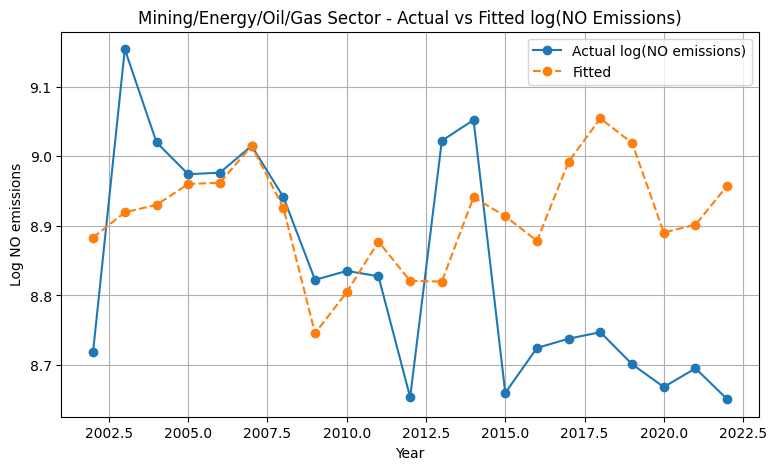

In [ ]:
# Step 6: plot actual vs fitted vs forcast
years = df_sec['year']
y_all_pred = lin_model2.predict(df_sec[features])

plt.figure(figsize=(9,5))

plt.plot(years,
         df_sec[target],
         marker='o',
         label = 'Actual log(NO emissions)')

plt.plot(years,
         y_all_pred,
         marker='o',
         linestyle='--',
         label='Fitted'
         )

plt.xlabel('Year')
plt.ylabel('Log NO emissions')
plt.title('Mining/Energy/Oil/Gas Sector - Actual vs Fitted log(NO Emissions)')
plt.legend()
plt.grid(True)
plt.show()


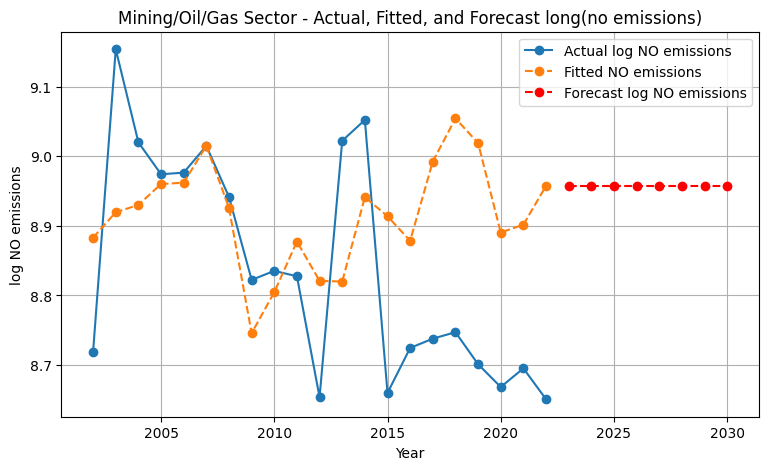

In [ ]:
# model future
# Step 1 : define prices map
price_df = pd.DataFrame({
    'year': [2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030],
    'carbon_price': [20, 30, 40, 50, 65, 80, 95, 110, 125, 140, 155, 170]
})

# Step 2 take 2022 values for other predictors
row_2022 = df_sec[df_sec['year'] == 2022].iloc[0]

# Step 3: build future feature table
future_years = price_df[price_df['year'] > 2022].copy()

# Create a dictionary for future_X data
future_X_data = {
    'gdp':row_2022['gdp'],
    'pop':row_2022['pop'],
    'net_energy_per_sector':row_2022['net_energy_per_sector'],
    'carbon_policy':row_2022['carbon_policy'],
    'carbon_price':future_years['carbon_price'],
    'price_x_high_emitters':row_2022['price_x_high_emitters'],
    'high_emitters':row_2022['high_emitters'],
    'distrupting_event_yr':row_2022['distrupting_event_yr']
}

# Create DataFrame and explicitly set the column order to match the 'features' list
future_X = pd.DataFrame(future_X_data, columns=features)

# Step 4: forecast emissions
future_pred = lin_model2.predict(future_X)
future_years['forecast_log_NO'] = future_pred

df_sec['fitted_log_NO'] = lin_model2.predict(df_sec[features])

# Step 5: plot actual emissions and forecast
plt.figure(figsize=(9,5))

# actual values
plt.plot(df_sec['year'],
         df_sec[target],
         marker='o',
         label='Actual log NO emissions')

#fitted actual
plt.plot(df_sec['year'],
         df_sec["fitted_log_NO"],
         marker='o',
         linestyle='--',
         label='Fitted NO emissions')


# Forecast
plt.plot(future_years['year'],
         future_years['forecast_log_NO'],
         marker='o',
         linestyle='--',
         color='red',
         label = 'Forecast log NO emissions')

plt.xlabel('Year')
plt.ylabel('log NO emissions')
plt.title('Mining/Oil/Gas Sector - Actual, Fitted, and Forecast long(no emissions)')
plt.legend()
plt.grid(True)
plt.show()

The secor specific model for log no emissions had rougly the same r squared values for train and test as the natinoally aggregated attempt with non-normalized co emissions. The RMSE however for this model was much smaller compared to the other model - this is probably due to the fact we used log emissions this time around especially if the r squared values are the same

Lets try log emissions for all sectors below

###Aggregation nationally all sectors log emissions

In [ ]:
# Step 1 : define the df

# Select cols from aggreageted df
cols = ['year',
        'sector_category',

        'log_carbon_monoxide',
        'log_nitrogen_oxides',

        'log_no_per_gdp',
        'log_co_per_gdp',

        'gdp',
        'pop',
        'net_energy_per_sector',

        'carbon_policy',
        'carbon_price',
        'price_x_high_emitters',
        'high_emitters',

       'distrupting_event_yr',
        ]

df_sec = df_national_agg[cols]

# Aggregate by sector- year
df_sec = (
    df_sec.groupby('year', as_index=False)
          .agg({
               'log_nitrogen_oxides': 'mean',
               'gdp': 'mean',
               'pop': 'mean',
               'net_energy_per_sector': 'mean',
               'carbon_policy': 'max',
               'carbon_price': 'max',
               'price_x_high_emitters': 'max',
               'high_emitters': 'max',
               'distrupting_event_yr': 'max'
          })
)


In [ ]:
# Step 2: select targets and features

target = 'log_nitrogen_oxides'

features = [
        'gdp',
        'pop',
        'net_energy_per_sector',
        'carbon_policy',
        'carbon_price',
        'price_x_high_emitters',
        'high_emitters',
       'distrupting_event_yr',
]

# Step 3 train/test/split
split_year = 2017

train_df = df_sec[df_sec['year'] < split_year]
test_df = df_sec[df_sec['year'] >= split_year]


X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]



# Step 4: fit model
lin_model2 = LinearRegression()
lin_model2.fit(X_train, y_train)

# Step 5 eval
y_train_pred = lin_model2.predict(X_train)
y_test_pred = lin_model2.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Train R²:", train_r2)
print("Test  R²:", test_r2)
print("Train RMSE:", train_rmse)
print("Test  RMSE:", test_rmse)

# Step 6: coeff
coeff_table = pd.DataFrame({
    'feature':['intercept'] + features,
    'beta':[lin_model2.intercept_] + list(lin_model2.coef_)
})



Train R²: 0.7741468816570606
Test  R²: -4.871134656313624
Train RMSE: 0.17817442770176323
Test  RMSE: 0.23684723334664123


Even worse r squared values when we aggregate by sectors

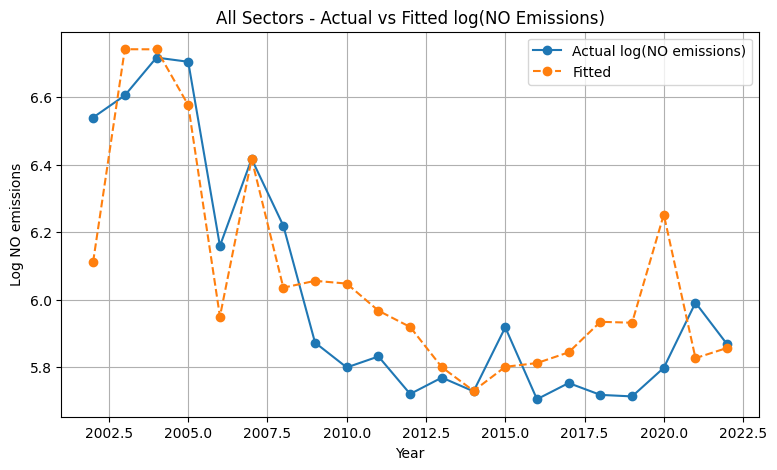

In [ ]:
# Step 6: plot actual vs fitted vs forcast
years = df_sec['year']
y_all_pred = lin_model2.predict(df_sec[features])

plt.figure(figsize=(9,5))

plt.plot(years,
         df_sec[target],
         marker='o',
         label = 'Actual log(NO emissions)')

plt.plot(years,
         y_all_pred,
         marker='o',
         linestyle='--',
         label='Fitted'
         )

plt.xlabel('Year')
plt.ylabel('Log NO emissions')
plt.title('All Sectors - Actual vs Fitted log(NO Emissions)')
plt.legend()
plt.grid(True)
plt.show()


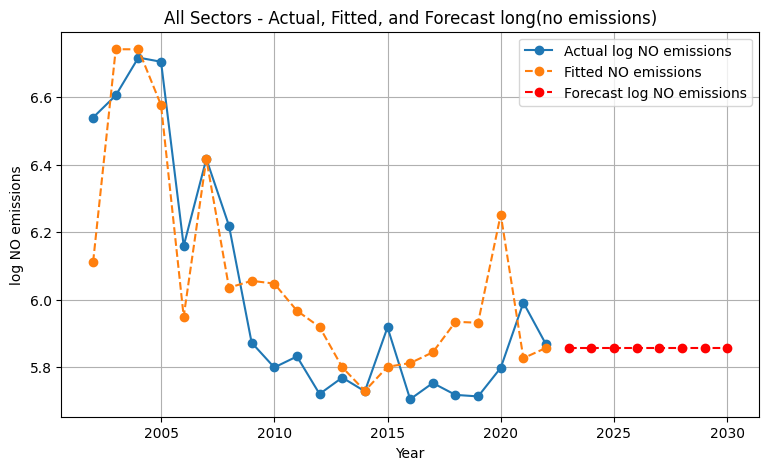

In [ ]:
# model future
# Step 1 : define prices map
price_df = pd.DataFrame({
    'year': [2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030],
    'carbon_price': [20, 30, 40, 50, 65, 80, 95, 110, 125, 140, 155, 170]
})

# Step 2 take 2022 values for other predictors
row_2022 = df_sec[df_sec['year'] == 2022].iloc[0]

# Step 3: build future feature table
future_years = price_df[price_df['year'] > 2022].copy()

# Create a dictionary for future_X data
future_X_data = {
    'gdp':row_2022['gdp'],
    'pop':row_2022['pop'],
    'net_energy_per_sector':row_2022['net_energy_per_sector'],
    'carbon_policy':row_2022['carbon_policy'],
    'carbon_price':future_years['carbon_price'],
    'price_x_high_emitters':row_2022['price_x_high_emitters'],
    'high_emitters':row_2022['high_emitters'],
    'distrupting_event_yr':row_2022['distrupting_event_yr']
}

# Create DataFrame and explicitly set the column order to match the 'features' list
future_X = pd.DataFrame(future_X_data, columns=features)

# Step 4: forecast emissions
future_pred = lin_model2.predict(future_X)
future_years['forecast_log_NO'] = future_pred

df_sec['fitted_log_NO'] = lin_model2.predict(df_sec[features])

# Step 5: plot actual emissions and forecast
plt.figure(figsize=(9,5))

# actual values
plt.plot(df_sec['year'],
         df_sec[target],
         marker='o',
         label='Actual log NO emissions')

#fitted actual
plt.plot(df_sec['year'],
         df_sec["fitted_log_NO"],
         marker='o',
         linestyle='--',
         label='Fitted NO emissions')


# Forecast
plt.plot(future_years['year'],
         future_years['forecast_log_NO'],
         marker='o',
         linestyle='--',
         color='red',
         label = 'Forecast log NO emissions')

plt.xlabel('Year')
plt.ylabel('log NO emissions')
plt.title('All Sectors - Actual, Fitted, and Forecast long(no emissions)')
plt.legend()
plt.grid(True)
plt.show()

Lets move to YOY values from log emissions as these reulsts are not looking great

Start with the mining sector yoy emissions for no

###Aggregate natinoally sector specific YOY values

In [ ]:
df_national_agg.columns

Index(['year', 'sector_category', 'co_emissions', 'no_emissions', 'gdp',
       'yoy_gdp', 'pop', 'yoy_pop', 'net_energy_per_sector', 'canada_gdp',
       'canada_yoy_gdp', 'sector_net_energy_per_canadian_gdp',
       'canada_energy_per_capita', 'canada_pop', 'canada_yoy_pop',
       'no_per_gdp', 'co_per_gdp', 'no_per_capita', 'co_per_capita', 'yoy_co',
       'yoy_no', 'log_nitrogen_oxides', 'log_carbon_monoxide',
       'log_no_per_gdp', 'log_co_per_gdp', 'carbon_policy', 'carbon_price',
       'high_emitters', 'price_x_high_emitters', 'distrupting_event_yr',
       'carbon', 'nitrogen'],
      dtype='object')

In [ ]:
# Step 1 : define df
sec_name = "Mining, Oil and Gas, Energy"
df_sec = df_national_agg[df_national_agg["sector_category"] == sec_name].copy()
df_sec = df_sec.sort_values("year")

# compute YoY predictors
# df_sec["yoy_carbon_price"] = df_sec["carbon_price"].pct_change() * 100
df_sec["yoy_energy"] = df_sec["net_energy_per_sector"].pct_change() * 100

# keep only rows after first valid YoY
df_sec = df_sec.dropna(subset=["yoy_no", "yoy_gdp", "yoy_pop",
                                "yoy_energy"])


# Step 2 : ffeatures

target = 'yoy_no'

features = [
    "yoy_gdp",            # economic growth
    "yoy_pop",            # population growth
    "yoy_energy",         # change in sector energy use
    "carbon_policy",      # 0/1: is federal carbon backstop in place?
    "distrupting_event_yr"  # COVID / shocks
]

# Step 3: train test split

split_year = 2017

train_df = df_sec[df_sec["year"] < split_year].copy()
test_df  = df_sec[df_sec["year"] >= split_year].copy()

X_train = train_df[features]
y_train = train_df[target]

X_test  = test_df[features]
y_test  = test_df[target]


# step 4: model
lin_yoy = LinearRegression()
lin_yoy.fit(X_train, y_train)

# Predictions
y_train_pred = lin_yoy.predict(X_train)
y_test_pred  = lin_yoy.predict(X_test)

# Metrics
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

train_r2   = r2_score(y_train, y_train_pred)
test_r2    = r2_score(y_test, y_test_pred)
train_rmse = rmse(y_train, y_train_pred)
test_rmse  = rmse(y_test, y_test_pred)

print("Train R² :", train_r2)
print("Train RMSE:", train_rmse)
print("Test  R² :", test_r2)
print("Test  RMSE:", test_rmse)

# Coeff table
coef_table = pd.DataFrame({
    "feature": ["intercept"] + features,
    "beta": [lin_yoy.intercept_] + list(lin_yoy.coef_)
})



Train R² : 0.32337295191872795
Train RMSE: 5.293996217716181
Test  R² : -1.335138485447457
Test  RMSE: 44.832766844904796


The test r squared for YOY no emissoins mining sector specific seems to be the lowest 'best' test score we've gotten compared to all models above. but the RMSE test value is incredibly high now. Most likely because we are lacking an incredible amount of data, especially when we drill down to a specific sector. In the OG data set there are years that have less reports compared to others.

Let's try a nantional aggregation to see any differences

###Agggregate nationally with all sectors yoy values

In [ ]:
# Step 1 — National yearly aggregation

nat = (
    df_national_agg
    .groupby('year', as_index=False)
    .agg({
        'co_emissions': 'sum',
        'no_emissions': 'sum',

        'gdp': 'mean',
        'pop': 'mean',
        'net_energy_per_sector': 'sum',

        'carbon_price': 'max',
        'carbon_policy': 'max',
        'distrupting_event_yr': 'max'
    })
)

# Step 2 — Compute YoY % change targets
nat['yoy_co'] = nat['co_emissions'].pct_change() * 100
nat['yoy_no'] = nat['no_emissions'].pct_change() * 100

# Step 3 — Compute YoY predictors
nat['yoy_gdp'] = nat['gdp'].pct_change() * 100
nat['yoy_pop'] = nat['pop'].pct_change() * 100
nat['yoy_energy'] = nat['net_energy_per_sector'].pct_change() * 100
# nat['yoy_carbon_price'] = nat['carbon_price'].pct_change() * 100

# Drop first year (no YoY available)
nat = nat.dropna().reset_index(drop=True)

target = 'yoy_no'

features = [
    "yoy_gdp",
    "yoy_pop",
    "yoy_energy",
    "carbon_policy",
    "distrupting_event_yr"
]


split_year = 2017

train_df = nat[nat['year'] < split_year]
test_df  = nat[nat['year'] >= split_year]

X_train = train_df[features]
y_train = train_df[target]

X_test  = test_df[features]
y_test  = test_df[target]

lin_nat = LinearRegression()
lin_nat.fit(X_train, y_train)

y_train_pred = lin_nat.predict(X_train)
y_test_pred  = lin_nat.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2  = r2_score(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse  = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Train R²:", train_r2)
print("Test R² :", test_r2)
print("Train RMSE:", train_rmse)
print("Test RMSE :", test_rmse)

Train R²: 0.23349095451032964
Test R² : -35.639011417930014
Train RMSE: 11.216118505276471
Test RMSE : 14.95838381128554


Moving on to a different model approaach. We are not getting good metrics with the yoy values nor log values for this sector (ie. Mining/Oil/Gas/Energy- one of the main emitting sectors). The value for r^2 especiially lets us know the model is doing worse than a horizontal line at the test mean.

We are not getting good values for yoy especially because this is even less data to work with comapared to log emissions. We cannot include the firt year in our data set as it is 0 YOY changes

##Attempt 3: Interrupted Time Series (ITS)
Lets try using interrupted time series on log emsissions. This will help us view the stats in a different manner hopfully. This approach is to see if there is even an impact of the policy on the emissions.

ITS is a research method that allows us to collect data at distinct intervals prior, during, and after specific events - in this case policy introductions. It understands the trends during these intervals and then compares them to identify changes such as slopes (ie. coefficients) or intercepts.



Model y = b_0 + b_1 *time + b_2 *policy+ b_3 * time_after_polict + epsilon

###Mining sector log no emissions

In [ ]:
import statsmodels.api as sm

# 1. Select sector
sec = "Mining, Oil and Gas, Energy"
df = df_national_agg[df_national_agg["sector_category"] == sec].copy()
df = df.sort_values("year")

# Use log nitrogen emissions
df["log_no"] = df["log_nitrogen_oxides"]

# 2. Create ITS variables
df["time"] = range(1, len(df) + 1)

policy_year = 2019
df["policy"] = (df["year"] >= policy_year).astype(int)

df["time_after_policy"] = df.apply(
    lambda row: row["year"] - policy_year + 1 if row["year"] >= policy_year else 0,
    axis=1
)

# Step 2 fit model
X = df[["time", "policy", "time_after_policy"]]
X = sm.add_constant(X)

y = df["log_no"]

its_model = sm.OLS(y, X).fit()
print(its_model.summary())




                            OLS Regression Results                            
Dep. Variable:                 log_no   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     4.438
Date:                Thu, 04 Dec 2025   Prob (F-statistic):             0.0177
Time:                        06:46:53   Log-Likelihood:                 15.369
No. Observations:                  21   AIC:                            -22.74
Df Residuals:                      17   BIC:                            -18.56
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 9.0141      0.06

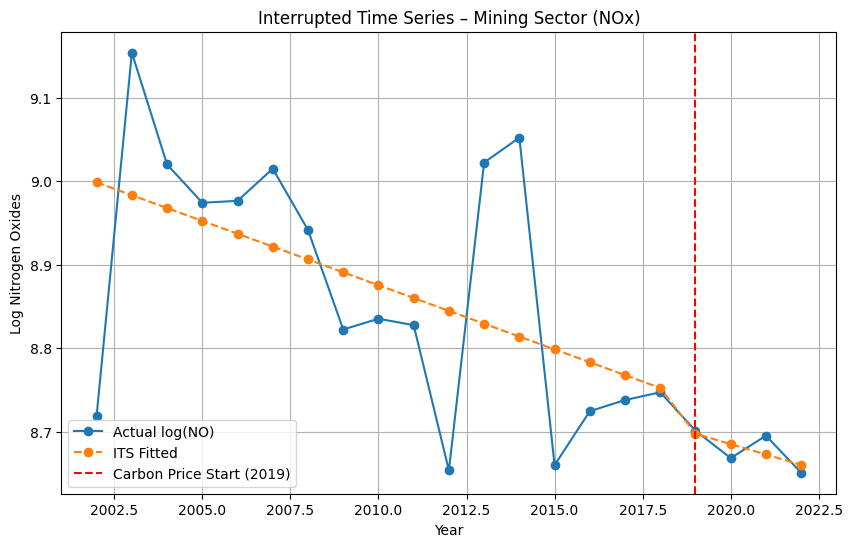

In [ ]:
df["fitted"] = its_model.predict(X)

plt.figure(figsize=(10,6))
plt.plot(df["year"], df["log_no"], marker="o", label="Actual log(NO)")
plt.plot(df["year"], df["fitted"], marker="o", linestyle="--", label="ITS Fitted")

plt.axvline(2019, color='red', linestyle='--', label="Carbon Price Start (2019)")

plt.xlabel("Year")
plt.ylabel("Log Nitrogen Oxides")
plt.title("Interrupted Time Series – Mining Sector (NOx)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
level_pct = (np.exp(its_model.params["policy"]) - 1) * 100
print("Immediate % change in NOx at 2019:", level_pct)

trend_pct = its_model.params["time_after_policy"] * 100
print("Change in annual trend after 2019:", trend_pct)


Immediate % change in NOx at 2019: -4.157448245128226
Change in annual trend after 2019: 0.2980635329790125


Interpretation of coefficient found in table for mining sector log(no) emissions
- baseline trend (time) = -0.0154, p = 0.028
    - before 2029 no emissions in the mining sector were already decrereasing each year (approx. 1.5% gotten from the formula:
    yearly change = ((e^coeff)-1)x100%
- policy (coeff=0.0425, p = 0.805)
    -measures the jump/drop in emissions in 2019
    - p-value is large - no statistical evidence of an immediant effect
    - percent change using same formula : 4.1%
- change in trend after policy (coeff = 0.0030, p=0.960)
    -test whether emissions declined faster after 2019
    - small coeff -> slighly slower decline but high p means no statistical evidence of post 2019 trend

This is tellign us for the mining sector for nitrogen emissions there was no signicant trends due to the carbon policy.

Try for CO in same sector

###Mining sector log emissions co

In [ ]:

# 1. Select sector
sec = "Mining, Oil and Gas, Energy"
df = df_national_agg[df_national_agg["sector_category"] == sec].copy()
df = df.sort_values("year")

# Use log nitrogen emissions
df["log_co"] = df["log_carbon_monoxide"]

# 2. Create ITS variables
df["time"] = range(1, len(df) + 1)

policy_year = 2019
df["policy"] = (df["year"] >= policy_year).astype(int)

df["time_after_policy"] = df.apply(
    lambda row: row["year"] - policy_year + 1 if row["year"] >= policy_year else 0,
    axis=1
)

# Step 2 fit model
X = df[["time", "policy", "time_after_policy"]]
X = sm.add_constant(X)

y = df["log_co"]

its_model = sm.OLS(y, X).fit()
print(its_model.summary())




                            OLS Regression Results                            
Dep. Variable:                 log_co   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     4.881
Date:                Thu, 04 Dec 2025   Prob (F-statistic):             0.0126
Time:                        07:01:10   Log-Likelihood:                 1.1787
No. Observations:                  21   AIC:                             5.643
Df Residuals:                      17   BIC:                             9.821
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 8.2618      0.12

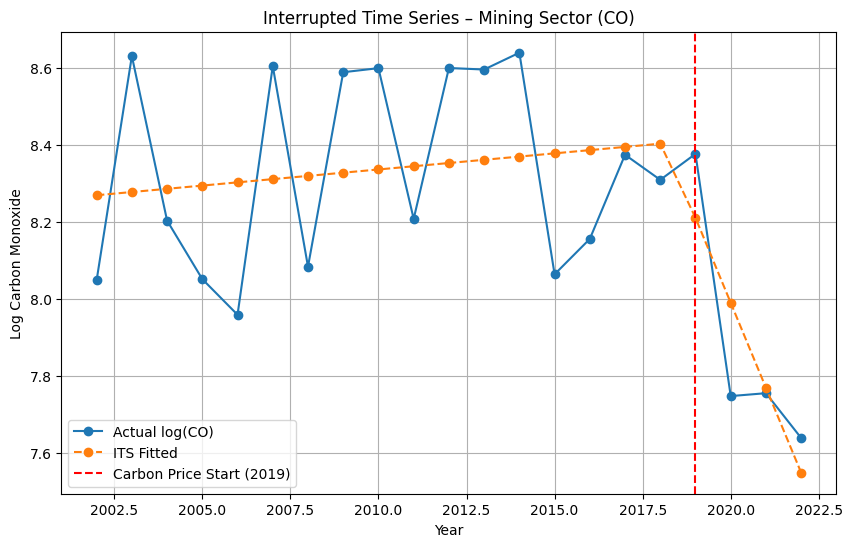

In [ ]:
df["fitted"] = its_model.predict(X)

plt.figure(figsize=(10,6))
plt.plot(df["year"], df["log_co"], marker="o", label="Actual log(CO)")
plt.plot(df["year"], df["fitted"], marker="o", linestyle="--", label="ITS Fitted")

plt.axvline(2019, color='red', linestyle='--', label="Carbon Price Start (2019)")

plt.xlabel("Year")
plt.ylabel("Log Carbon Monoxide")
plt.title("Interrupted Time Series – Mining Sector (CO)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
level_pct = (np.exp(its_model.params["policy"]) - 1) * 100
print("Immediate % change in NOx at 2019:", level_pct)

trend_pct = its_model.params["time_after_policy"] * 100
print("Change in annual trend after 2019:", trend_pct)


Immediate % change in NOx at 2019: 2.841561744949228
Change in annual trend after 2019: -22.89481707851348


Interpretation of log CO emissions for minnig/gass...
- base trend = 0.0084, p = 0.515
    - before 2019 CO emissions showed no meaningful trend
    - annual change of 0.84% for coeff using the formula stated previously
    - high p value -> not statistically significant
- policy level change 2019
    - large p value -> no statistical evidence emissions changged in 2019 due to policy
- change in trend after policy (p=0.062)
    -p value is slightly above the 0.05 threshold -> borderline evidence that eemissions began decreasing faster

There is suggestive evidence of a faster downward trend in the years following the introduction of carbon pricing due to the p value in the change in trend after policy

Try a different sector

###Manufacturing and industrial sector log co emissions

In [ ]:
df_national_agg['sector_category'].unique()

array(['Agriculture, Forestry, Fishing, Hunting', 'Construction',
       'Manufacturing and Industrial', 'Mining, Oil and Gas, Energy',
       'Public Admin', 'Transportation'], dtype=object)

In [ ]:

# 1. Select sector
sec = "Manufacturing and Industrial"
df = df_national_agg[df_national_agg["sector_category"] == sec].copy()
df = df.sort_values("year")

# Use log nitrogen emissions
df["log_co"] = df["log_carbon_monoxide"]N

# 2. Create ITS variables
df["time"] = range(1, len(df) + 1)

policy_year = 2019
df["policy"] = (df["year"] >= policy_year).astype(int)

df["time_after_policy"] = df.apply(
    lambda row: row["year"] - policy_year + 1 if row["year"] >= policy_year else 0,
    axis=1
)

# Step 2 fit model
X = df[["time", "policy", "time_after_policy"]]
X = sm.add_constant(X)

y = df["log_co"]

its_model = sm.OLS(y, X).fit()
print(its_model.summary())




                            OLS Regression Results                            
Dep. Variable:                 log_co   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     6.636
Date:                Thu, 04 Dec 2025   Prob (F-statistic):            0.00362
Time:                        07:10:54   Log-Likelihood:                 8.4721
No. Observations:                  21   AIC:                            -8.944
Df Residuals:                      17   BIC:                            -4.766
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 9.4174      0.09

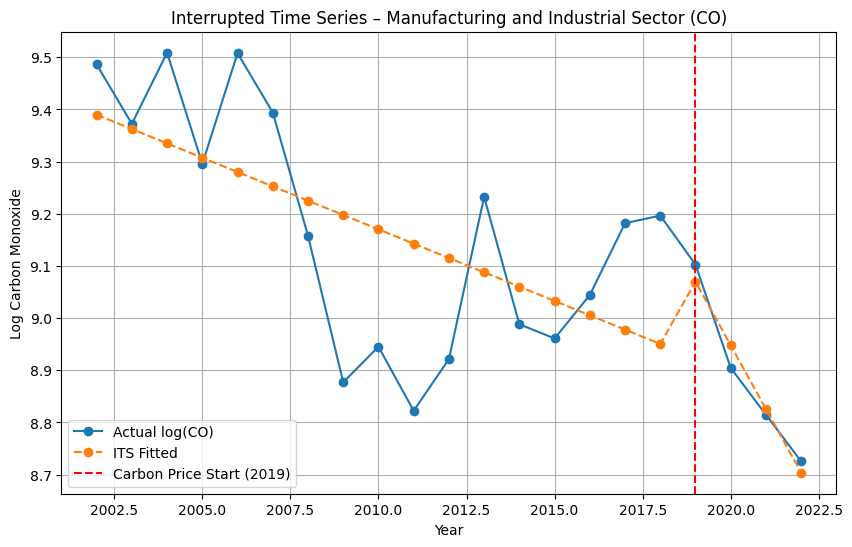

In [ ]:
df["fitted"] = its_model.predict(X)

plt.figure(figsize=(10,6))
plt.plot(df["year"], df["log_co"], marker="o", label="Actual log(CO)")
plt.plot(df["year"], df["fitted"], marker="o", linestyle="--", label="ITS Fitted")

plt.axvline(2019, color='red', linestyle='--', label="Carbon Price Start (2019)")

plt.xlabel("Year")
plt.ylabel("Log Carbon Monoxide")
plt.title("Interrupted Time Series – Manufacturing and Industrial Sector (CO)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
level_pct = (np.exp(its_model.params["policy"]) - 1) * 100
print("Immediate % change in CO at 2019:", level_pct)

trend_pct = its_model.params["time_after_policy"] * 100
print("Change in annual trend after 2019:", trend_pct)


Immediate % change in CO at 2019: 27.342100966350568
Change in annual trend after 2019: -9.469903572008688


Using the same analytical method as the mining/gass sector we can conclude:

CO emissions were already on a significant downward trajectory before the policy, Coefficients suggest a possible level increase in 2019 and a faster decline afterward, the stat. evidence is insufficient to conclude that the carbon pricing policy produced a measurebale effect on CO emissions in this sector

###Manufacturing and industrial log no emissions

NO emissions for manufacturing

In [ ]:

# 1. Select sector
sec = "Manufacturing and Industrial"
df = df_national_agg[df_national_agg["sector_category"] == sec].copy()
df = df.sort_values("year")

# Use log nitrogen emissions
df["log_no"] = df["log_nitrogen_oxides"]

# 2. Create ITS variables
df["time"] = range(1, len(df) + 1)

policy_year = 2019
df["policy"] = (df["year"] >= policy_year).astype(int)

df["time_after_policy"] = df.apply(
    lambda row: row["year"] - policy_year + 1 if row["year"] >= policy_year else 0,
    axis=1
)

# Step 2 fit model
X = df[["time", "policy", "time_after_policy"]]
X = sm.add_constant(X)

y = df["log_no"]

its_model = sm.OLS(y, X).fit()
print(its_model.summary())




                            OLS Regression Results                            
Dep. Variable:                 log_no   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     92.10
Date:                Thu, 04 Dec 2025   Prob (F-statistic):           1.03e-10
Time:                        07:16:26   Log-Likelihood:                 27.949
No. Observations:                  21   AIC:                            -47.90
Df Residuals:                      17   BIC:                            -43.72
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 9.0333      0.03

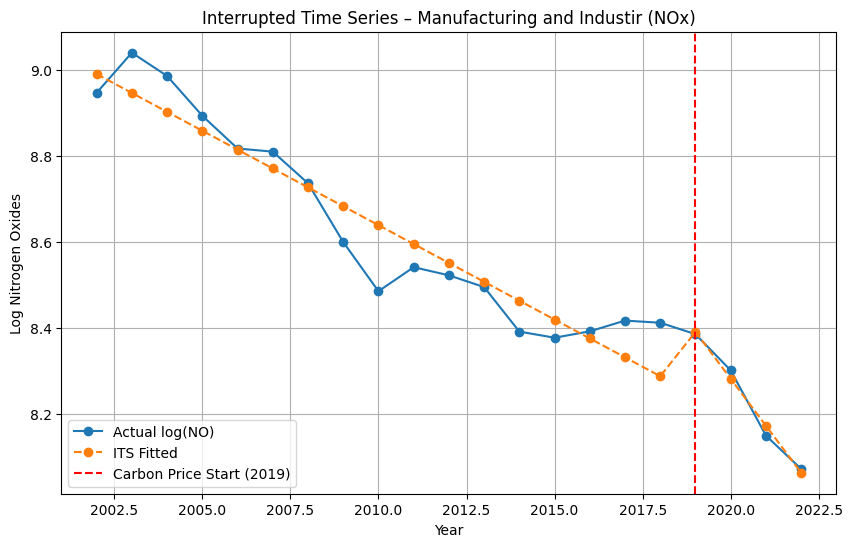

In [ ]:
df["fitted"] = its_model.predict(X)

plt.figure(figsize=(10,6))
plt.plot(df["year"], df["log_no"], marker="o", label="Actual log(NO)")
plt.plot(df["year"], df["fitted"], marker="o", linestyle="--", label="ITS Fitted")

plt.axvline(2019, color='red', linestyle='--', label="Carbon Price Start (2019)")

plt.xlabel("Year")
plt.ylabel("Log Nitrogen Oxides")
plt.title("Interrupted Time Series – Manufacturing and Industir (NOx)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
level_pct = (np.exp(its_model.params["policy"]) - 1) * 100
print("Immediate % change in No at 2019:", level_pct)

trend_pct = its_model.params["time_after_policy"] * 100
print("Change in annual trend after 2019:", trend_pct)


Immediate % change in No at 2019: 23.650726199067762
Change in annual trend after 2019: -6.526127529710404


- baseline trend
     - already declining emissions (4.3% - coeff. of pre policy section)
- policy
    - 23.7 % increase in NO emissions at the start of the carbon pricing period
    - p = 0.036 -> statistically significant meaning a leal level shift occuring in 2019
- after ppolciy
    - emissions declined an additional 6.5% per year
    - p value near 0.05 -> borderline significant



###Transportation sector log co

In [ ]:

# 1. Select sector
sec = "Transportation"
df = df_national_agg[df_national_agg["sector_category"] == sec].copy()
df = df.sort_values("year")

# Use log nitrogen emissions
df["log_co"] = df["log_carbon_monoxide"]

# 2. Create ITS variables
df["time"] = range(1, len(df) + 1)

policy_year = 2019
df["policy"] = (df["year"] >= policy_year).astype(int)

df["time_after_policy"] = df.apply(
    lambda row: row["year"] - policy_year + 1 if row["year"] >= policy_year else 0,
    axis=1
)

# Step 2 fit model
X = df[["time", "policy", "time_after_policy"]]
X = sm.add_constant(X)

y = df["log_co"]

its_model = sm.OLS(y, X).fit()
print(its_model.summary())




                            OLS Regression Results                            
Dep. Variable:                 log_co   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     1.745
Date:                Thu, 04 Dec 2025   Prob (F-statistic):              0.196
Time:                        07:23:41   Log-Likelihood:                -6.2458
No. Observations:                  21   AIC:                             20.49
Df Residuals:                      17   BIC:                             24.67
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 6.6813      0.18

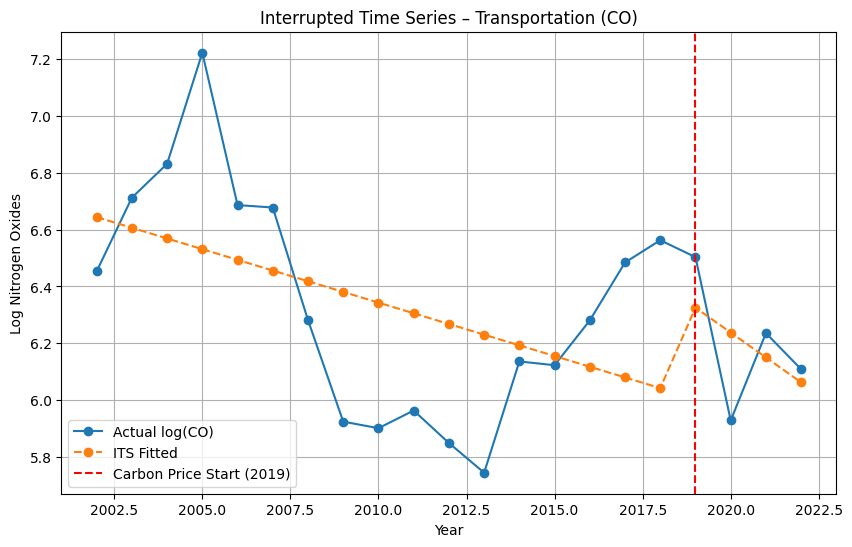

In [ ]:
df["fitted"] = its_model.predict(X)

plt.figure(figsize=(10,6))
plt.plot(df["year"], df["log_co"], marker="o", label="Actual log(CO)")
plt.plot(df["year"], df["fitted"], marker="o", linestyle="--", label="ITS Fitted")

plt.axvline(2019, color='red', linestyle='--', label="Carbon Price Start (2019)")

plt.xlabel("Year")
plt.ylabel("Log Nitrogen Oxides")
plt.title("Interrupted Time Series – Transportation (CO)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
level_pct = (np.exp(its_model.params["policy"]) - 1) * 100
print("Immediate % change in CO at 2019:", level_pct)

trend_pct = its_model.params["time_after_policy"] * 100
print("Change in annual trend after 2019:", trend_pct)


Immediate % change in CO at 2019: 44.83182490602113
Change in annual trend after 2019: -4.9999848030677665


CO emissions had a long term downward trend prior to policy but the ITS model finds no statisticcal evidence of immediate shift at or after policy (no statistical significance showing policy impact through high p values).

These ITS models have told us:
- for the manufacturing and industrial sector log(no) emissions
    - we see a statistically significant (ie. small p value) for after policy time, however as emissions were already on the decline this could be due to this - we cannot say for sure
- for every other emission and insustry we don't see any statistical significance of the policy having an impact

##Attempt 4: Re-run with new energy consumption data set; true province-sector-year grain
Note: we realized that the energy consumption info we had was for a national aggregation right from the source. We went back and found a provincial level aggregation of this (was not found before do to user error - aka we overlooked this). In terms of our national level aggregations above this won't be an issue. However let's re-run some of the attempts above when we view from a province-sector-emission-year grain

###Stats rolling window model on log emissions all features

In [ ]:
# New province-year-substance-sector data
df_prov = pd.read_csv('npri_ext_fe_v5.csv')
df_prov.columns

Index(['Unnamed: 0', 'year', 'province', 'sector_category', 'co_emissions',
       'no_emissions', 'gdp', 'yoy_gdp', 'pop', 'yoy_pop',
       'net_energy_per_sector', 'no_per_gdp', 'co_per_gdp', 'no_per_capita',
       'co_per_capita', 'carbon_policy', 'carbon_price', 'high_emitters',
       'price_x_high_emitters', 'yoy_co', 'yoy_no', 'log_nitrogen_oxides',
       'log_carbon_monoxide', 'log_no_per_gdp', 'log_co_per_gdp',
       'distrupting_event_yr', 'carbon', 'nitrogen'],
      dtype='object')

In [ ]:
import statsmodels.api as sm


def rolling_forecast_sector_prov(df, sector_name, prov_name, target_col, features, window=8):
  sec_df = df[(df['sector_category']==sector_name) & (df['province'] == prov_name)].copy()

  # Sort by year
  sec_df = sec_df.sort_values('year')

  # Extract years
  years = sorted(sec_df['year'].unique())

  results = []

  for i in range(len(years) - window):
    # Define the train/test years
    train_years = years[i:i+window]
    test_year = years[i+window]

    # Create train/test dfs
    train_df = sec_df[sec_df['year'].isin(train_years)]
    test_df = sec_df[sec_df['year'] == test_year]

    # # Check if we have enough rows to fit a model
    # if len(train_df) < len(features) + 2:
    #   continue

    # only keep features that have variation
    valid_features = [f for f in features if train_df[f].nunique() >1]
    if len(valid_features) == 0:
      continue

    # Define features
    X_train = sm.add_constant(train_df[valid_features])
    y_train = train_df[target_col]

    model = sm.OLS(y_train, X_train).fit()

    # Evaluation R2
    train_r2 = model.rsquared

    # Test prediction
    if len(test_df) > 0:
      X_test = sm.add_constant(test_df[valid_features], has_constant='add')
      y_test = test_df[target_col]
      y_pred = model.predict(X_test)

      #Mean-Squared-Error
      mse = np.mean((y_test-y_pred)**2)
      mae = np.mean(np.abs(y_test-y_pred))
    else:
      mse = np.nan
      mae = np.nan

    # Store results
    results.append({
        'sector':sector_name,
        'province':prov_name,
        'target':target_col,
        'train_start_year':train_years[0],
        'train_end_year':train_years[-1],
        'test_year':test_year,
        'train_len':len(train_df),
        'test_len':len(test_df),
        'train_r2':train_r2,
        'test_mse':mse,
        'test_mae':mae,
        'features':valid_features,
        **{f"beta_{col}":model.params.get(col,np.nan) for col in valid_features}
    })

  return pd.DataFrame(results)



# Define base features that all sector models will use
base_features = [
    'carbon_price',
    'carbon_policy',
    'gdp',
    'pop',
    'net_energy_per_sector'
]


# Define the sectors
sectors = df_prov['sector_category'].unique().tolist()

# Define the provvinces
provinces = df_prov['province'].unique().tolist()

# Start off wit these targets
# Can potentially add more:
targets = [
    'log_carbon_monoxide',
    'log_nitrogen_oxides',
    'log_co_per_gdp',
    'log_no_per_gdp'
]

all_roll_win_res_prov = []

for target in targets:
  # iterate through the sectors
  for sec in sectors:
    for prov in provinces:
      res = rolling_forecast_sector_prov(
          df = df_prov,
          sector_name = sec,
          prov_name = prov,
          target_col = target,
          features= base_features,
          window=8
      )

      # Append all results
      all_roll_win_res_prov.append(res)


all_roll_win_res_prov = pd.concat(all_roll_win_res_prov, ignore_index=True)


In [ ]:
from matplotlib.lines import lineStyles
import matplotlib.pyplot as plt
import seaborn as sns

# Plot for rolling coeff paths (ie. beta values)

def coeff_viz(df_viz, target, sector, province, feature):
  # Select one target and sector
  subset = df_viz[(df_viz['target'] == target) & (df_viz['sector'] == sector) & (df_viz['province'] == province)].copy()

  # Check
  if subset.empty:
    print(f"No data for {sector} / {target} / {province}")
    return

  # Plot
  plt.figure(figsize=(9,5))
  plt.plot(subset['test_year'], subset[feature], marker='o')

  plt.axhline(0, color='black', linestyle='--')
  plt.title(f"Rolling Coeffecient Path:\n{feature} -> {target} ({sector} / {province})")
  plt.xlabel("Test Year")
  plt.ylabel("Coefficient Value")
  plt.grid(True)
  plt.show()


In [ ]:
all_roll_win_res_prov['sector'].unique()

array(['Manufacturing and Industrial', 'Mining, Oil and Gas, Energy',
       'Transportation', 'Agriculture, Forestry, Fishing, Hunting',
       'Construction', 'Public Admin'], dtype=object)

In [ ]:
all_roll_win_res_prov['province'].unique()

array(['AB', 'BC', 'MB', 'NB', 'NL', 'NS', 'ON', 'PE', 'QC', 'SK', 'NT',
       'NU', 'YT'], dtype=object)

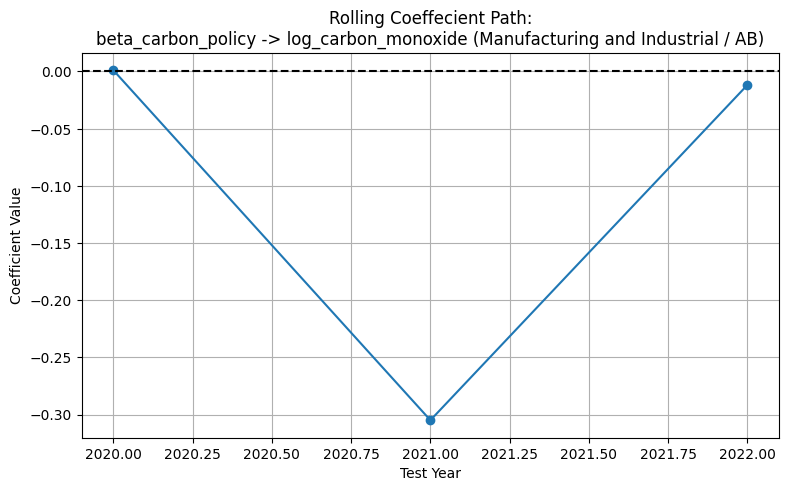

In [ ]:
coeff_viz(all_roll_win_res_prov,
          target='log_carbon_monoxide',
          sector='Manufacturing and Industrial',
          province = 'AB',
          feature='beta_carbon_policy')
# print("\n\n")
# coeff_viz(all_roll_win_res_nat,
#           target='log_carbon_monoxide',
#           sector='Mining, Oil and Gas, Energy',
#           feature='beta_pop')
# print("\n\n")
# coeff_viz(all_roll_win_res_nat,
#           target='log_carbon_monoxide',
#           sector='Mining, Oil and Gas, Energy',
#           feature='beta_gdp')
# print("\n\n")
# coeff_viz(all_roll_win_res_nat,
#           target='log_carbon_monoxide',
#           sector='Mining, Oil and Gas, Energy',
#           feature='beta_net_energy_per_sector')

Move on to forcasting

In [ ]:
# Baseline prov-sector for 2022
baseline_2022 = (
    df_prov[df_prov['year'] == 2022]
    .groupby(['province','sector_category'], as_index=False)
    .agg({
        "co_emissions":'sum',
        'no_emissions':'sum'
    })


# Future carbon pricing table
price_df = pd.DataFrame({
    'year': [2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030],
    'carbon_price': [20, 30, 40, 50, 65, 80, 95, 110, 125, 140, 155, 170]
})

# Base price nad year
base_year = 2022
base_price = price_df.loc[price_df['year'] == base_year, 'carbon_price'].iloc[0]

# Convert beta (carbon_price) to % change for fufture prices
# Step 2: Create a helper function to compute % change from b_price
def emission_change_simulation(beta_price, price_df, base_price):
  """
  Given a carbon price coeff. from a log emissions model compute the & change
  in emissions for each future carbon price relative to the baseline price
  """

  df_sim = price_df.copy()
  df_sim['delta_price'] = df_sim['carbon_price'] - base_price

  # dela(log(emissions)) = beta * delta price
  df_sim['delta_log_emissions'] = beta_price * df_sim['delta_price']

  # % change = (exp)
  df_sim['pct_change_emissions'] = (np.exp(df_sim['delta_log_emissions']) - 1) * 100

  return df_sim


# Extract latest beta values for each prov-sector-target
# Use last available test year for each group
latest_betas = (
    all_roll_win_res_prov
    .sort_values("test_year")
    .groupby(["province", "sector", "target"])
    .tail(1)
)

# Keep only targets with log emissions
latest_betas = latest_betas[
    latest_betas["target"].isin(["log_carbon_monoxide", "log_nitrogen_oxides"])
]

# build forecast table
forecast_results = []

for _, row in latest_betas.iterrows():
  prov = row['province']
  sec = row['sector']
  target = row['target']
  beta_price = row['beta_carbon_price']

  # Check on coeff for beta price
  if pd.isna(beta_price):
    continue

  # % change  forcast
  sim = emission_change_simulation(beta_price, price_df, base_price)
  sim['province'] = prov
  sim['sector'] = sec
  sim['target'] = target

  # Merge with basseline emissions
  base_row = baseline_2022[
      (baseline_2022['province'] == prov) &
      (baseline_2022['sector_category'] == sec)
  ]

  if base_row.empty:
    continue

  base_co = base_row['co_emissions'].iloc[0]
  base_no = base_row['no_emissions'].iloc[0]

  # Attach sabeline depending on target type
  sim['baseline'] = base_co if target == 'log_carbon_monoxide' else base_no

  sim['predicted_emissions'] = sim['baseline'] * (1+sim['pct_change_emissions']/100)

  forecast_results.append(sim)

forecast_results = pd.concat(forecast_results, ignore_index = True)








In [ ]:
def plot_prov_sector(df_prov, forecast_df, province, sector, gas):

    gas_map = {
        "log_carbon_monoxide": ("co_emissions", "CO Emissions"),
        "log_nitrogen_oxides": ("no_emissions", "NOx Emissions")
    }

    target = "log_carbon_monoxide" if gas == "co" else "log_nitrogen_oxides"
    raw_col, label = gas_map[target]

    # actual emissions
    actual = (
        df_prov[(df_prov["province"] == province) &
                (df_prov["sector_category"] == sector)]
        .groupby("year")[raw_col].sum()
        .reset_index()
    )

    # forecast emissions
    fc = forecast_df[
        (forecast_df["province"] == province) &
        (forecast_df["sector"] == sector) &
        (forecast_df["target"] == target)
    ]

    plt.figure(figsize=(9,5))

    plt.plot(actual["year"], actual[raw_col], marker='o', label="Actual")
    plt.plot(fc["year"], fc["predicted_emissions"], marker='o',
             linestyle="--", label="Forecast")

    plt.title(f"{province} — {sector}\n{label}: Actual vs Forecast (2022–2030)")
    plt.xlabel("Year")
    plt.ylabel("Emissions (tonnes)")
    plt.grid(True)
    plt.legend()
    plt.show()


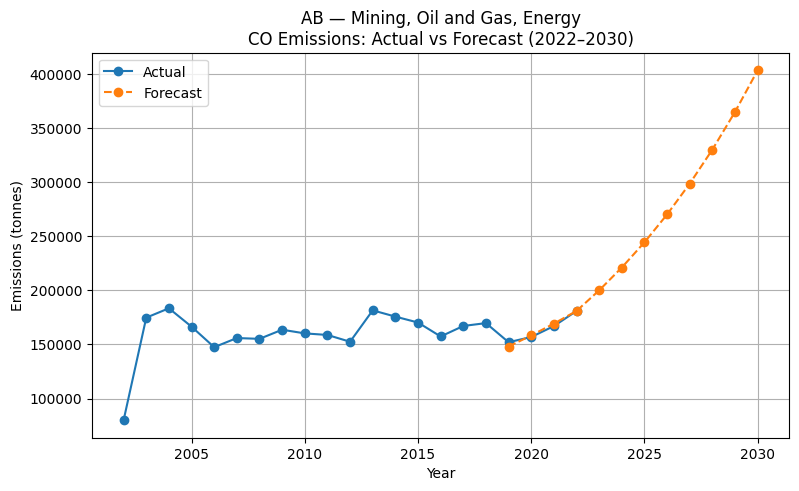

In [ ]:
plot_prov_sector(df_prov, forecast_results,
                 province="AB",
                 sector="Mining, Oil and Gas, Energy",
                 gas="co")


We definitely see a reduction of forecasting emission values from our first take (ie. using the sector-national levels). The model is still however predicting large emission increases for this sector

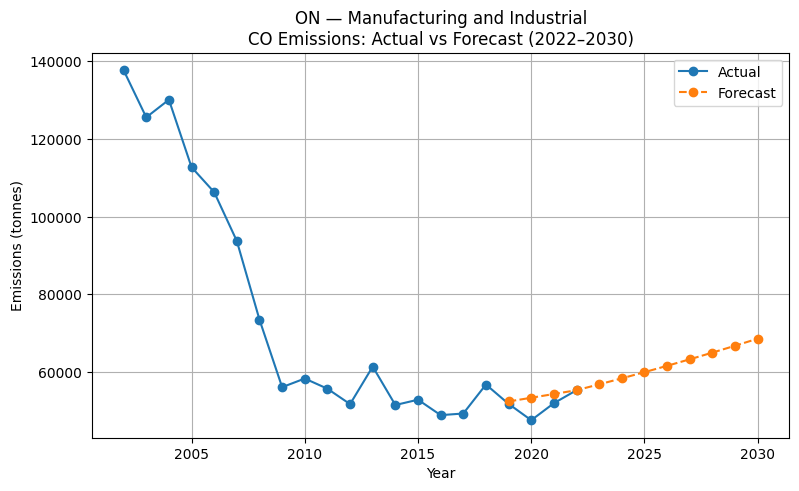

In [ ]:
plot_prov_sector(df_prov, forecast_results,
                 province="ON",
                 sector="Manufacturing and Industrial",
                 gas="co")


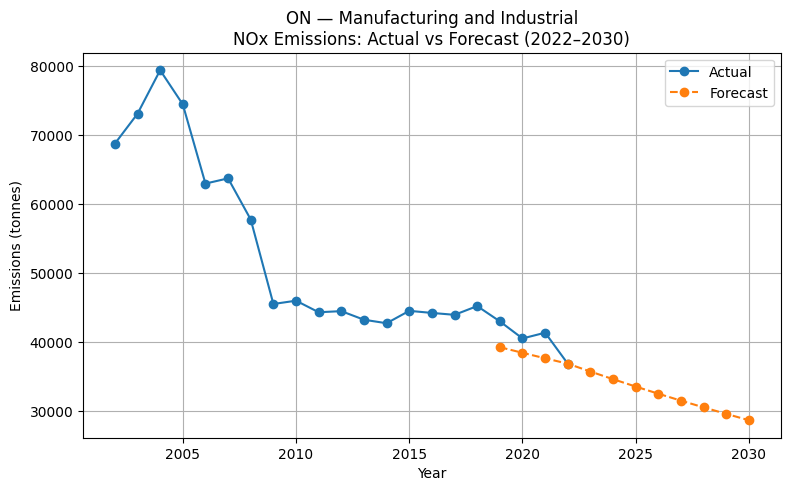

In [ ]:
plot_prov_sector(df_prov, forecast_results,
                 province="ON",
                 sector="Manufacturing and Industrial",
                 gas="no")


It seems if the last year is on a decreasing trend (ie. everything up to 2022) then the predictions are also decreasing, other wise they are increasing. This makes sense as this model is only trained on a window size of 8 years - looking at how big our data is, especially once you filter it for sector and provinces, it becomes even smaller. If ther is a general decrease in the 8 years this will show across forecast.

Note: I have trained on ON this time around as all other provinces are using their own carbon pricing. However, the federal system should still be able to roughly estimate the provicial level pricing as the federal levels are a base model.

Lets try to rework the linear regression model to account for province-sector-

###Linear regression on straight emissions (ie. non normalized)

In [ ]:
df_prov.columns

Index(['Unnamed: 0', 'year', 'province', 'sector_category', 'co_emissions',
       'no_emissions', 'gdp', 'yoy_gdp', 'pop', 'yoy_pop',
       'net_energy_per_sector', 'no_per_gdp', 'co_per_gdp', 'no_per_capita',
       'co_per_capita', 'carbon_policy', 'carbon_price', 'high_emitters',
       'price_x_high_emitters', 'yoy_co', 'yoy_no', 'log_nitrogen_oxides',
       'log_carbon_monoxide', 'log_no_per_gdp', 'log_co_per_gdp',
       'distrupting_event_yr', 'carbon', 'nitrogen'],
      dtype='object')

In [ ]:
df_ps

,year,province,sector_category,co_emissions,no_emissions,carbon_price,carbon_policy,gdp,pop,net_energy_per_sector,price_x_high_emitters,high_emitters,distrupting_event_yr
0,2002,AB,Manufacturing and Industrial,58289.840000,36226.484230,0.0,0,103963.4,3128757.0,987501.0,0.0,1,0
1,2002,AB,"Mining, Oil and Gas, Energy",79904.736000,149463.157000,0.0,0,89312.9,3128757.0,4013034.0,0.0,1,0
2,2002,AB,Transportation,2224.545000,7105.815000,0.0,0,10172.8,3128757.0,104590.0,0.0,0,0
3,2002,BC,"Agriculture, Forestry, Fishing, Hunting",4335.284000,354.826000,0.0,0,5365.7,4100504.0,25213.0,0.0,0,0
4,2002,BC,Manufacturing and Industrial,132931.705000,24187.852000,0.0,0,57381.1,4100504.0,318538.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,2022,QC,Transportation,58.884090,115.383990,50.0,1,16924.2,8669963.0,120777.0,0.0,0,0
794,2022,SK,Manufacturing and Industrial,19454.680756,3292.341604,50.0,1,29211.8,1178796.0,128807.0,50.0,1,0
795,2022,SK,"Mining, Oil and Gas, Energy",17764.028690,41465.623756,50.0,1,27256.6,1178796.0,1220751.0,50.0,1,0
796,2022,SK,Transportation,965.092810,2904.892320,50.0,1,3542.4,1178796.0,48433.0,0.0,0,0


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np



# Aggregate df_prov at the correct grain
df_ps = (
    df_prov
    .groupby(["year", "province", "sector_category"], as_index=False)
    .agg({
        "co_emissions": "sum",
        "no_emissions": "sum",
        "carbon_price": "max",
        "carbon_policy": "max",
        "gdp": "mean",
        "pop": "mean",
        "net_energy_per_sector": "sum",
        "price_x_high_emitters": "max",
        "high_emitters": "max",
        "distrupting_event_yr": "max"
    })
)



def run_linear_regression_ps(df, province, sector, target_col, feature_cols, split_year=2017):
    # Filter one province-sector slice
    df_slice = df[(df["province"] == province) &
                  (df["sector_category"] == sector)].copy()

    df_slice = df_slice.sort_values("year")

    if df_slice.empty:
        print("No data for selection:", province, sector)
        return None

    # --- Define X, y ---
    X = df_slice[feature_cols]
    y = df_slice[target_col]
    years = df_slice["year"].values

    # --- Train/test split ---
    train_mask = df_slice["year"] < split_year
    test_mask  = df_slice["year"] >= split_year

    X_train, y_train = X[train_mask], y[train_mask]
    X_test,  y_test  = X[test_mask], y[test_mask]
    years_train = years[train_mask]
    years_test  = years[test_mask]

    # Not enough training data?
    if len(X_train) < len(feature_cols) + 1:
        print("Not enough training data for:", province, sector)
        return None

    # --- Fit model ---
    model = LinearRegression()
    model.fit(X_train, y_train)

    # --- Predictions ---
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    # --- Metrics ---
    def rmse(a, b): return np.sqrt(mean_squared_error(a, b))

    metrics = {
        "train_r2": r2_score(y_train, y_train_pred),
        "test_r2":  r2_score(y_test, y_test_pred) if len(y_test) > 0 else np.nan,
        "train_rmse": rmse(y_train, y_train_pred),
        "test_rmse":  rmse(y_test,  y_test_pred) if len(y_test) > 0 else np.nan,
    }

    # --- Beta coefficients ---
    coef_table = pd.DataFrame({
        "feature": ["intercept"] + feature_cols,
        "beta": [model.intercept_] + list(model.coef_)
    })

    # --- Output dictionary ---
    return {
        "province": province,
        "sector": sector,
        "target": target_col,
        "model": model,
        "metrics": metrics,
        "coef_table": coef_table,
        "years": years,
        "actual": y.values,
        "fitted": model.predict(X)
    }

feature_cols = [
    "carbon_price",
    "carbon_policy",
    "gdp",
    "pop",
    "net_energy_per_sector",
    "price_x_high_emitters",
    'high_emitters',
    'distrupting_event_yr'
]


In [ ]:
result = run_linear_regression_ps(
    df=df_ps,
    province="AB",
    sector="Mining, Oil and Gas, Energy",
    target_col="co_emissions",
    feature_cols=feature_cols,
    split_year=2017
)
result["metrics"]


{'train_r2': 0.16725620575262035,
 'test_r2': -2.5938899166668987,
 'train_rmse': np.float64(21465.756025214556),
 'test_rmse': np.float64(17595.445526886007)}

In [ ]:
result_on_manufact = run_linear_regression_ps(
    df=df_ps,
    province="ON",
    sector="Manufacturing and Industrial",
    target_col="no_emissions",
    feature_cols=feature_cols,
    split_year=2017
)
result_on_manufact["metrics"]

{'train_r2': 0.9447861120017474,
 'test_r2': -4.525898082484432,
 'train_rmse': np.float64(3058.9118108128596),
 'test_rmse': np.float64(6359.085599013913)}

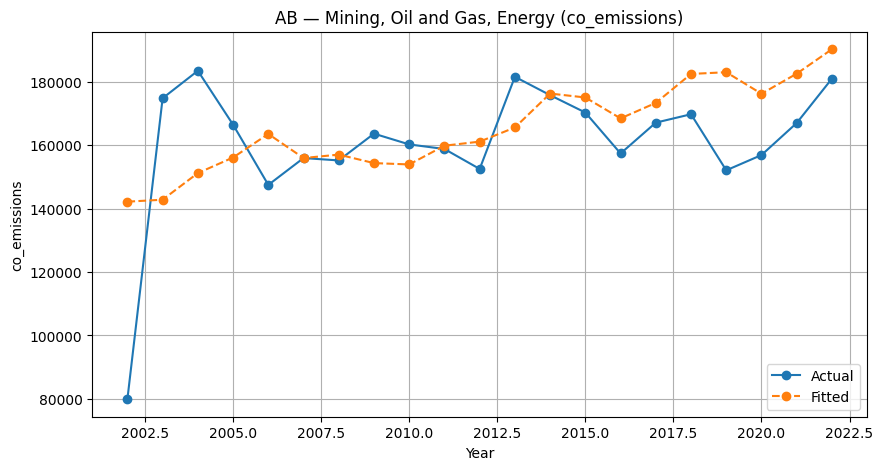

In [ ]:
import matplotlib.pyplot as plt

years = result["years"]
actual = result["actual"]
fitted = result["fitted"]

plt.figure(figsize=(10,5))
plt.plot(years, actual, marker="o", label="Actual")
plt.plot(years, fitted, marker="o", linestyle="--", label="Fitted")
plt.title(f"{result['province']} — {result['sector']} ({result['target']})")
plt.xlabel("Year")
plt.ylabel(result["target"])
plt.grid(True)
plt.legend()
plt.show()


This looks overfit

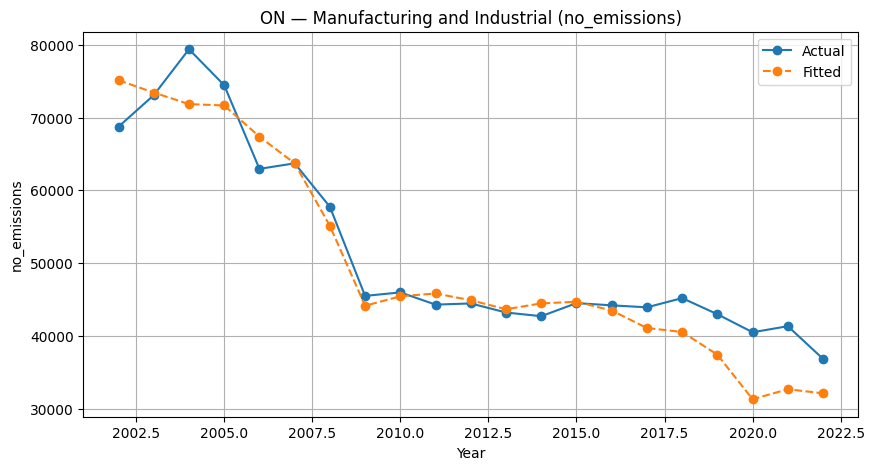

In [ ]:
years = result_on_manufact["years"]
actual = result_on_manufact["actual"]
fitted = result_on_manufact["fitted"]

plt.figure(figsize=(10,5))
plt.plot(years, actual, marker="o", label="Actual")
plt.plot(years, fitted, marker="o", linestyle="--", label="Fitted")
plt.title(f"{result_on_manufact['province']} — {result_on_manufact['sector']} ({result_on_manufact['target']})")
plt.xlabel("Year")
plt.ylabel(result_on_manufact["target"])
plt.grid(True)
plt.legend()
plt.show()

Lets try forecasting

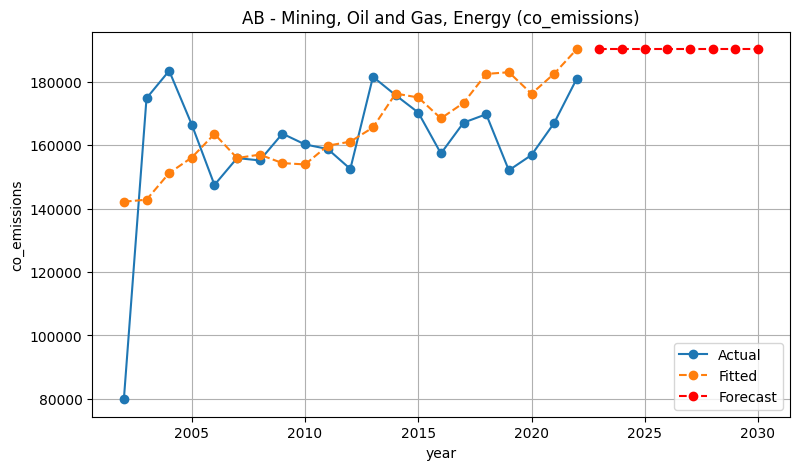

In [ ]:
# model future
# Step 1 : define prices map
price_df = pd.DataFrame({
    'year': [2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030],
    'carbon_price': [20, 30, 40, 50, 65, 80, 95, 110, 125, 140, 155, 170]
})


# Select correct province sector values
prov = result['province']
sector = result['sector']
target_col = result['target']

df_slice = df_ps[(df_ps['province'] == prov) &
                 (df_ps['sector_category'] == sector)].copy()
df_slice = df_slice.sort_values('year')

# Extract 2022 values
row_2022 = df_slice[df_slice['year'] == 2022].iloc[0].copy()

future_X_data = {}

# Define future_years here, as it's needed in the loop
future_years = price_df[price_df['year'] > 2022].copy()

for col in feature_cols:
  if col == 'carbon_price':
    future_X_data[col] = future_years['carbon_price']
  else:
    #Carry forward 2022 values for other features
    future_X_data[col] = row_2022[col]

future_X = pd.DataFrame(future_X_data, columns=feature_cols)

# Forecast future emissions
future_pred = result['model'].predict(future_X)
future_years['forecast'] = future_pred
# Add fitted values to historical data
df_slice['fitted'] = result['model'].predict(df_slice[feature_cols])


# Plot
plt.figure(figsize=(9,5))

# Historical/actual
plt.plot(df_slice['year'], df_slice[target_col],
         marker = 'o',
         label="Actual")

# Fitted historical
plt.plot(df_slice['year'], df_slice['fitted'],
         marker = 'o',
         linestyle='--',
         label="Fitted")

# Forecast
plt.plot(future_years['year'], future_years['forecast'],
                      marker='o',
                      linestyle='--',
                      color='red',
                      label='Forecast')

plt.title(f"{prov} - {sector} ({target_col})")
plt.xlabel("year")
plt.ylabel(target_col)
plt.grid(True)
plt.legend()
plt.show()

These forecasts are not very good...

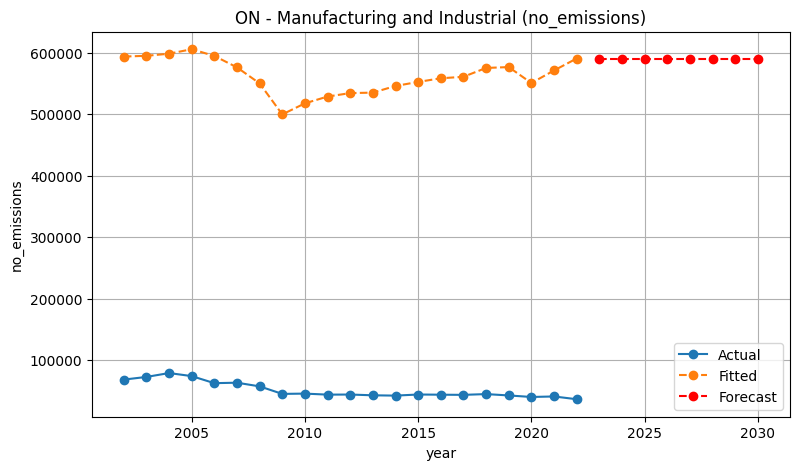

In [ ]:
# model future
# Step 1 : define prices map
price_df = pd.DataFrame({
    'year': [2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030],
    'carbon_price': [20, 30, 40, 50, 65, 80, 95, 110, 125, 140, 155, 170]
})


# Select correct province sector values
prov = result_on_manufact['province']
sector = result_on_manufact['sector']
target_col = result_on_manufact['target']

df_slice = df_ps[(df_ps['province'] == prov) &
                 (df_ps['sector_category'] == sector)].copy()
df_slice = df_slice.sort_values('year')

# Extract 2022 values
row_2022 = df_slice[df_slice['year'] == 2022].iloc[0].copy()

future_X_data = {}

# Define future_years here, as it's needed in the loop
future_years = price_df[price_df['year'] > 2022].copy()

for col in feature_cols:
  if col == 'carbon_price':
    future_X_data[col] = future_years['carbon_price']
  else:
    #Carry forward 2022 values for other features
    future_X_data[col] = row_2022[col]

future_X = pd.DataFrame(future_X_data, columns=feature_cols)

# Forecast future emissions
future_pred = result['model'].predict(future_X)
future_years['forecast'] = future_pred
# Add fitted values to historical data
df_slice['fitted'] = result['model'].predict(df_slice[feature_cols])


# Plot
plt.figure(figsize=(9,5))

# Historical/actual
plt.plot(df_slice['year'], df_slice[target_col],
         marker = 'o',
         label="Actual")

# Fitted historical
plt.plot(df_slice['year'], df_slice['fitted'],
         marker = 'o',
         linestyle='--',
         label="Fitted")

# Forecast
plt.plot(future_years['year'], future_years['forecast'],
                      marker='o',
                      linestyle='--',
                      color='red',
                      label='Forecast')

plt.title(f"{prov} - {sector} ({target_col})")
plt.xlabel("year")
plt.ylabel(target_col)
plt.grid(True)
plt.legend()
plt.show()

##Summary at initial attempt
- started off exploring national level aggregation for different features and targets using stats model on rolling regressions
  - predictors such as the beta coeff's for carbon pricing/policy were flat/constant
- linear regression produced high training r squared values but extremely poor r squared (overfit)
- next a look into ITS (Interrupted Time Series) to see if we could detect policy level effects through p values (causal analysis)
    - for each sector we modeled the policy impact divided into three sections: time, policy, and time after policy
        - mining/gas/energy sector
            - NO emissions : no significant effect of carbon policy
            - CO emissions: weak.no significant policy impact
        - manufacturing and industrial sector
            - NO emissions: strong decreasing trend before policy, small additional shift post policy
            - CO emissions: immediate positive change but statistically weak
        - transportation sector
            - CO: no significant structural break from policy
    - did not exmaine further as the other sectors produced far less emissions
- rebuilt the data set using provincial energy consumption data (previously overlooked the fact that this too was available as a provinicial level aggregate)
    - re-ran models with the provincial-year-emissions-sector grain to see if this led to better conclusions
        - rolling window stats model
            - shows a smaller emissions increase as compared to the national levels (still unrealistic however as the increase/decrease is upwards/downwards depending on what the last 8 year window trend was)
            - better than national level ssince the windows were showing much more variation so that the coeffiecients were actual changing values
            - larger data set to train on (20 as opposed to 8)
        - linear regression
            - still showed negative r squared values
            - the forecasted values were constant same as the national level

As we can see through using a variey of models:
- modeling this problem is extremely difficult; from the lack of data (ie. training sets only consisting of a handful of values (8-12 in some cases) to the external factors (economic) it is very hard to poinpoint the casual relationship between emissions and carbon pricing
- emission models behave differenly at different granularites (future steps could include aggregating provincial models to obtain national)
    - national models fail in the models seen in this notebook
    - province-sector models capture real variation
- carbon price effects are sector dependant (ovbious), small, and statistically insignificant for the large emitting sectors (Mining/Oil/Gas/Energy, Manufacturing/Industrial, Transportation)


What this means:
- this was a beginner level attempt at modeling something complex such as emissions in econometrics; this means that our modeling definitely needs work and perhaps different aprroaches
- what we can gather from our results above:
    - for large sectorial emitters (Mining/Oil/Gas, Manufacturing/Industrial) in large emitting provinces (AB and ON) we can see slight varations in emissions due to the policy impacy
        - for NO emissions in ON they weere already declining prior to the change - this makes it difficult to conclude that it was in part due to the policy effect
  - more data is neeed, perhaps something even on the daily emissions level or monthly rather than yearly; this makes it difficult to train data properly especially if we choose to aggregate it based on sectorial features and provincial
  

# Second approach/attempt


In [ ]:
#Imports for dataframe

import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv("NPRI_2000-2022.csv", encoding='latin1')

/tmp/ipython-input-3688687181.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("NPRI_2000-2022.csv", encoding='latin1')


In [ ]:
df.shape

(737516, 28)

In [ ]:
df.dtypes

,0
Reporting_Year / Année,int64
NPRI_ID / No_INRP,int64
Number of employees,object
Company_Name / Dénomination_sociale_de_l'entreprise,object
Facility_Name / Installation,object
NAICS / Code_SCIAN,int64
NAICS Title / Titre Code_SCIAN,object
PROVINCE,object
City,object
Latitude,float64


In [ ]:
filtered_df = df[df['Substance Name (English) / Nom de substance (Anglais)'].isin([
    'Carbon monoxide',
    'Nitrogen oxides (expressed as nitrogen dioxide)'
])].copy()

In [ ]:
filtered_df.shape

(133430, 28)

In [ ]:
filtered_df.isna().sum()

,0
Reporting_Year / Année,0
NPRI_ID / No_INRP,0
Number of employees,145
Company_Name / Dénomination_sociale_de_l'entreprise,0
Facility_Name / Installation,51
NAICS / Code_SCIAN,0
NAICS Title / Titre Code_SCIAN,0
PROVINCE,0
City,30251
Latitude,384


In [ ]:
filtered_df

,Reporting_Year / Année,NPRI_ID / No_INRP,Number of employees,Company_Name / Dénomination_sociale_de_l'entreprise,Facility_Name / Installation,NAICS / Code_SCIAN,NAICS Title / Titre Code_SCIAN,PROVINCE,City,Latitude,...,Release to Air - Spills,Release to Air - Stack / Point,Release to Air - Storage / Handling,Releases to Land - Leaks,Releases to Land - Other,Releases to Land - Spills,Releases to Water Bodies - Direct Discharges,Releases to Water Bodies - Leaks,Releases to Water Bodies - Spills,Sum of release to all media (<1tonne)
20037,2002,1,440,ALBERTA PACIFIC FOREST INDUSTRIES,(blank),322112,Chemical pulp mills,AB,County of Athabasca,54.923116,...,NaN,1376.8300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20040,2002,1,440,ALBERTA PACIFIC FOREST INDUSTRIES,(blank),322112,Chemical pulp mills,AB,County of Athabasca,54.923116,...,NaN,1763.1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20065,2002,4,450,TEMBEC INDUSTRIES,PINE FALLS OPERATIONS,322122,Newsprint mills,MB,PINE FALLS,50.568600,...,NaN,260.8030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20077,2002,4,450,TEMBEC INDUSTRIES,PINE FALLS OPERATIONS,322122,Newsprint mills,MB,PINE FALLS,50.568600,...,NaN,2850.8540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20177,2002,54,850,NORANDA INC.,Brunswick Mine,212231,Lead-zinc ore mining,NB,BATHURST,47.471700,...,NaN,453.5700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737480,2022,33871,NaN,Coastal Resources Ltd.,Freeman 1-11-66-13W5,211110,Oil and gas extraction (except oil sands),AB,Swan Hills,54.693400,...,NaN,0.9600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
737488,2022,33875,2.0,Response Energy Corp.,08-27-036-06W5 Oil SWB,211110,Oil and gas extraction (except oil sands),AB,Garrington,52.120900,...,NaN,1.2822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
737489,2022,33875,2.0,Response Energy Corp.,08-27-036-06W5 Oil SWB,211110,Oil and gas extraction (except oil sands),AB,Garrington,52.120900,...,NaN,2.7497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
737500,2022,33878,170.0,B2Gold Back River Corporation,Goose Project,212220,Gold and silver ore mining,NU,Goose Lake,65.544927,...,NaN,39.6186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
filtered_df.columns = filtered_df.columns.str.strip()
filtered_df.dropna(subset=['Release to Air - Stack / Point'], inplace=True)

In [ ]:
relevant_columns = [
    'Reporting_Year / Année',
    'PROVINCE',
    'NAICS / Code_SCIAN',
    'Substance Name (English) / Nom de substance (Anglais)',
    'Release to Air - Stack / Point'
]

filtered_df = filtered_df[relevant_columns]

In [ ]:
filtered_df = filtered_df.copy()
filtered_df.rename(columns={
    'Reporting_Year / Année': 'year',
    'PROVINCE': 'province',
    'NAICS / Code_SCIAN': 'naics',
    'Substance Name (English) / Nom de substance (Anglais)': 'substance',
    'Release to Air - Stack / Point': 'emissions'
}, inplace=True)

In [ ]:
filtered_df

,year,province,naics,substance,emissions
20037,2002,AB,322112,Nitrogen oxides (expressed as nitrogen dioxide),1376.8300
20040,2002,AB,322112,Carbon monoxide,1763.1500
20065,2002,MB,322122,Nitrogen oxides (expressed as nitrogen dioxide),260.8030
20077,2002,MB,322122,Carbon monoxide,2850.8540
20177,2002,NB,212231,Nitrogen oxides (expressed as nitrogen dioxide),453.5700
...,...,...,...,...,...
737480,2022,AB,211110,Carbon monoxide,0.9600
737488,2022,AB,211110,Nitrogen oxides (expressed as nitrogen dioxide),1.2822
737489,2022,AB,211110,Carbon monoxide,2.7497
737500,2022,NU,212220,Nitrogen oxides (expressed as nitrogen dioxide),39.6186


In [ ]:
#Cut everything but the first 3 digits of the NAICS codes.
filtered_df['naics'] = filtered_df['naics'].astype(str).str[:3]

In [ ]:
#How many unique codes do we have?
filtered_df['naics'].unique()

array(['322', '212', '211', '325', '336', '331', '311', '562', '221',
       '115', '326', '324', '312', '327', '321', '911', '113', '213',
       '333', '332', '323', '335', '541', '339', '337', '237', '111',
       '622', '314', '611', '486', '488', '493', '418', '313', '417',
       '416', '623', '412', '334', '112', '812', '315', '531', '811',
       '481', '316', '482', '484', '561', '721'], dtype=object)

In [ ]:
# Count number of rows per NAICS 3-digit code
naics_counts = filtered_df['naics'].value_counts().sort_index()

print(naics_counts)

naics
111       69
112        2
113       21
115       28
211    85385
212     3356
213      948
221     8426
237      268
311     1873
312      274
313       12
314       43
315       34
316        2
321     5882
322     3445
323       68
324     1667
325     3322
326      392
327     2074
331     2036
332      494
333      113
334       13
335       35
336      810
337       96
339      177
412       13
416        3
417        1
418       79
481       34
482       10
484        4
486     4415
488       70
493       97
531       11
541       61
561        2
562     1050
611      710
622      282
623        4
721        5
811        9
812       12
911      275
Name: count, dtype: int64


In [ ]:
# Count rows per NAICS code
naics_counts = filtered_df['naics'].value_counts()

# Keep only codes with at least 100 rows
valid_naics = naics_counts[naics_counts >= 100].index

# Filter dataframe inplace
filtered_df = filtered_df[filtered_df['naics'].isin(valid_naics)]

In [ ]:
# Count number of rows per NAICS 3-digit code
naics_counts = filtered_df['naics'].value_counts().sort_index()

print(naics_counts)

naics
211    85385
212     3356
213      948
221     8426
237      268
311     1873
312      274
321     5882
322     3445
324     1667
325     3322
326      392
327     2074
331     2036
332      494
333      113
336      810
339      177
486     4415
562     1050
611      710
622      282
911      275
Name: count, dtype: int64


In [ ]:
# Aggregate emissions
filtered_df = filtered_df.groupby(
    ['province', 'year', 'naics', 'substance'], as_index=False
)['emissions'].sum()

# Reset index just to be sure
filtered_df.reset_index(drop=True, inplace=True)

filtered_df.head()

,province,year,naics,substance,emissions
0,AB,2002,211,Carbon monoxide,70509.546
1,AB,2002,211,Nitrogen oxides (expressed as nitrogen dioxide),61796.464
2,AB,2002,212,Nitrogen oxides (expressed as nitrogen dioxide),303.380
3,AB,2002,213,Carbon monoxide,93.400
4,AB,2002,213,Nitrogen oxides (expressed as nitrogen dioxide),400.460


In [ ]:
filtered_df.shape

(5406, 5)

In [ ]:
#Get the mergies
gdp_df = pd.read_csv('3610071101_databaseLoadingData.csv')

In [ ]:
gdp_df

,REF_DATE,GEO,DGUID,Prices,North American Industry Classification System (NAICS),UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2002,Newfoundland and Labrador,2021A000210,Chained (2017) dollars,Oil and gas extraction [211],Dollars,81,millions,6,v1793281822,1.2.29,5472.8,NaN,NaN,NaN,1
1,2003,Newfoundland and Labrador,2021A000210,Chained (2017) dollars,Oil and gas extraction [211],Dollars,81,millions,6,v1793281822,1.2.29,6384.2,NaN,NaN,NaN,1
2,2004,Newfoundland and Labrador,2021A000210,Chained (2017) dollars,Oil and gas extraction [211],Dollars,81,millions,6,v1793281822,1.2.29,5997.2,NaN,NaN,NaN,1
3,2005,Newfoundland and Labrador,2021A000210,Chained (2017) dollars,Oil and gas extraction [211],Dollars,81,millions,6,v1793281822,1.2.29,5890.1,NaN,NaN,NaN,1
4,2006,Newfoundland and Labrador,2021A000210,Chained (2017) dollars,Oil and gas extraction [211],Dollars,81,millions,6,v1793281822,1.2.29,5904.9,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6274,2018,Nunavut,2021A000262,Chained (2017) dollars,Federal government public administration [911],Dollars,81,millions,6,v1793290927,13.2.242,112.7,NaN,NaN,NaN,1
6275,2019,Nunavut,2021A000262,Chained (2017) dollars,Federal government public administration [911],Dollars,81,millions,6,v1793290927,13.2.242,113.5,NaN,NaN,NaN,1
6276,2020,Nunavut,2021A000262,Chained (2017) dollars,Federal government public administration [911],Dollars,81,millions,6,v1793290927,13.2.242,113.9,NaN,NaN,NaN,1
6277,2021,Nunavut,2021A000262,Chained (2017) dollars,Federal government public administration [911],Dollars,81,millions,6,v1793290927,13.2.242,117.8,NaN,NaN,NaN,1


In [ ]:
gdp_df['NAICS_3'] = gdp_df['North American Industry Classification System (NAICS)'].str.extract(r'\[([^\]]+)\]')  # grabs the code inside []
gdp_df['NAICS_3'] = gdp_df['NAICS_3'].str[:3]  # keeps only first 3 digits

In [ ]:
gdp_df['NAICS_3'].unique()

array(['211', '212', '213', '22', '23B', '311', '312', '321', '322',
       '324', '325', '326', '327', '331', '332', '333', '336', '339',
       '486', '562', '61', '622', '911'], dtype=object)

In [ ]:
gdp_df['NAICS_3'] = gdp_df['NAICS_3'].replace({
    '22': '221',
    '23B': '237',
    '61': '611',
    '91': '911'
})

In [ ]:
# Get unique codes from each dataframe
gdp_codes = gdp_df['NAICS_3'].unique()
npri_codes = filtered_df['naics'].unique()

# Show both
print("GDP codes:", gdp_codes)
print("NPRI codes:", npri_codes)

# Codes in NPRI but not in GDP
print("In NPRI but not in GDP:", set(npri_codes) - set(gdp_codes))

# Codes in GDP but not in NPRI
print("In GDP but not in NPRI:", set(gdp_codes) - set(npri_codes))

GDP codes: ['211' '212' '213' '221' '237' '311' '312' '321' '322' '324' '325' '326'
 '327' '331' '332' '333' '336' '339' '486' '562' '611' '622' '911']
NPRI codes: ['211' '212' '213' '221' '311' '312' '321' '322' '324' '325' '327' '331'
 '339' '486' '562' '611' '336' '622' '333' '237' '911' '332' '326']
In NPRI but not in GDP: set()
In GDP but not in NPRI: set()


In [ ]:
relevant_columns = [
    'REF_DATE',
    'GEO',
    'VALUE',
    'NAICS_3',
]

gdp_df = gdp_df[relevant_columns]

In [ ]:
province_map = {
    'Newfoundland and Labrador': 'NL',
    'Prince Edward Island': 'PE',
    'Nova Scotia': 'NS',
    'New Brunswick': 'NB',
    'Quebec': 'QC',
    'Ontario': 'ON',
    'Manitoba': 'MB',
    'Saskatchewan': 'SK',
    'Alberta': 'AB',
    'British Columbia': 'BC',
    'Yukon': 'YT',
    'Northwest Territories': 'NT',
    'Nunavut': 'NU'
}


gdp_df['province'] = gdp_df['GEO'].map(province_map)

/tmp/ipython-input-2253684640.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdp_df['province'] = gdp_df['GEO'].map(province_map)


In [ ]:
gdp_df.drop(columns=['GEO'],inplace=True)

/tmp/ipython-input-2675648940.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdp_df.drop(columns=['GEO'],inplace=True)


In [ ]:
print(gdp_df.columns)

Index(['REF_DATE', 'VALUE', 'NAICS_3', 'province'], dtype='object')


In [ ]:
# Rename columns
gdp_df.rename(columns={'REF_DATE': 'year', 'VALUE': 'gdp'}, inplace=True)

# Merge with filtered_df
merged_df = filtered_df.merge(
    gdp_df[['year', 'province', 'NAICS_3', 'gdp']],
    how='left',
    left_on=['year', 'province', 'naics'],
    right_on=['year', 'province', 'NAICS_3']
)

# Drop the redundant column
merged_df.drop(columns=['NAICS_3'], inplace=True)

# Sanity check
print(merged_df['gdp'].isna().sum())

0


/tmp/ipython-input-2864739680.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdp_df.rename(columns={'REF_DATE': 'year', 'VALUE': 'gdp'}, inplace=True)


In [ ]:
merged_df

,province,year,naics,substance,emissions,gdp
0,AB,2002,211,Carbon monoxide,70509.5460,27975.5
1,AB,2002,211,Nitrogen oxides (expressed as nitrogen dioxide),61796.4640,27975.5
2,AB,2002,212,Nitrogen oxides (expressed as nitrogen dioxide),303.3800,961.9
3,AB,2002,213,Carbon monoxide,93.4000,6306.1
4,AB,2002,213,Nitrogen oxides (expressed as nitrogen dioxide),400.4600,6306.1
...,...,...,...,...,...,...
5401,YT,2021,221,Nitrogen oxides (expressed as nitrogen dioxide),843.6875,59.6
5402,YT,2022,212,Carbon monoxide,68.9587,213.8
5403,YT,2022,212,Nitrogen oxides (expressed as nitrogen dioxide),319.9036,213.8
5404,YT,2022,221,Carbon monoxide,431.6884,60.1


In [ ]:
#population time
pop_df = pd.read_csv('1710000501_databaseLoadingData.csv')

In [ ]:
#same GEO conversion as before

pop_df['province'] = pop_df['GEO'].map(province_map)

In [ ]:
relevant_columns = [
    'REF_DATE',
    'VALUE',
    'province',
]

pop_df = pop_df[relevant_columns]

In [ ]:
# Rename columns
pop_df.rename(columns={'REF_DATE': 'year', 'VALUE': 'pop'}, inplace=True)

# Merge with what we already merged
merged_df = merged_df.merge(
    pop_df[['year', 'province', 'pop']],
    how='left',
    left_on=['year', 'province'],
    right_on=['year', 'province']
)

# Sanity check
print(merged_df['pop'].isna().sum())

0


In [ ]:
# Initialize column with 0
merged_df['carbon_price'] = 0

# Assign prices for the years 2019-2022
carbon_prices = {2019: 20, 2020: 30, 2021: 40, 2022: 50}

merged_df['carbon_price'] = merged_df['year'].map(carbon_prices).fillna(0)

In [ ]:
merged_df

,province,year,naics,substance,emissions,gdp,pop,carbon_price
0,AB,2002,211,Carbon monoxide,70509.5460,27975.5,3128757,0.0
1,AB,2002,211,Nitrogen oxides (expressed as nitrogen dioxide),61796.4640,27975.5,3128757,0.0
2,AB,2002,212,Nitrogen oxides (expressed as nitrogen dioxide),303.3800,961.9,3128757,0.0
3,AB,2002,213,Carbon monoxide,93.4000,6306.1,3128757,0.0
4,AB,2002,213,Nitrogen oxides (expressed as nitrogen dioxide),400.4600,6306.1,3128757,0.0
...,...,...,...,...,...,...,...,...
5401,YT,2021,221,Nitrogen oxides (expressed as nitrogen dioxide),843.6875,59.6,42961,40.0
5402,YT,2022,212,Carbon monoxide,68.9587,213.8,43869,50.0
5403,YT,2022,212,Nitrogen oxides (expressed as nitrogen dioxide),319.9036,213.8,43869,50.0
5404,YT,2022,221,Carbon monoxide,431.6884,60.1,43869,50.0


##Model 1: Just predict emissions over time. Nothing else.

In [ ]:
# Aggregate total emissions per year per substance
total_emissions = merged_df.groupby(['year', 'substance'])['emissions'].sum().reset_index()

print(total_emissions)

    year                                        substance      emissions
0   2002                                  Carbon monoxide  785614.265000
1   2002  Nitrogen oxides (expressed as nitrogen dioxide)  568325.266880
2   2003                                  Carbon monoxide  839905.977000
3   2003  Nitrogen oxides (expressed as nitrogen dioxide)  828369.820688
4   2004                                  Carbon monoxide  950352.042000
5   2004  Nitrogen oxides (expressed as nitrogen dioxide)  837227.818500
6   2005                                  Carbon monoxide  947485.253000
7   2005  Nitrogen oxides (expressed as nitrogen dioxide)  830708.359300
8   2006                                  Carbon monoxide  942279.048000
9   2006  Nitrogen oxides (expressed as nitrogen dioxide)  818281.495000
10  2007                                  Carbon monoxide  929354.162000
11  2007  Nitrogen oxides (expressed as nitrogen dioxide)  824254.210200
12  2008                                  Carbon mo

In [ ]:
# For Carbon monoxide
co_df = total_emissions[total_emissions['substance'] == 'Carbon monoxide'].reset_index(drop=True)

# For Nitrogen oxides
nox_df = total_emissions[total_emissions['substance'] == 'Nitrogen oxides (expressed as nitrogen dioxide)'].reset_index(drop=True)

# Drop the 'substance' column since it's redundant now
co_df = co_df.drop(columns='substance')
nox_df = nox_df.drop(columns='substance')

In [ ]:
from sklearn.linear_model import LinearRegression

# Function to train and forecast
def forecast_linear(frame, years_to_predict):
    X = frame[['year']]
    y = frame['emissions']

    # Train linear regression
    model = LinearRegression()
    model.fit(X, y)

    # Predict future years
    future_years = pd.DataFrame({'year': years_to_predict})
    predictions = model.predict(future_years)

    forecast_df = future_years.copy()
    forecast_df['predicted_emissions'] = predictions
    return forecast_df

# Forecast years
future_years = [2023, 2024, 2025, 2026, 2027, 2028]

# CO forecast
co_forecast = forecast_linear(co_df, future_years)

# NOx forecast
nox_forecast = forecast_linear(nox_df, future_years)

print("CO forecast:\n", co_forecast)
print("\nNOx forecast:\n", nox_forecast)

CO forecast:
    year  predicted_emissions
0  2023        803299.151975
1  2024        798583.795804
2  2025        793868.439632
3  2026        789153.083461
4  2027        784437.727290
5  2028        779722.371119

NOx forecast:
    year  predicted_emissions
0  2023        475029.992861
1  2024        459291.207624
2  2025        443552.422386
3  2026        427813.637148
4  2027        412074.851911
5  2028        396336.066673


We'll plot the initial prediction to the graph.

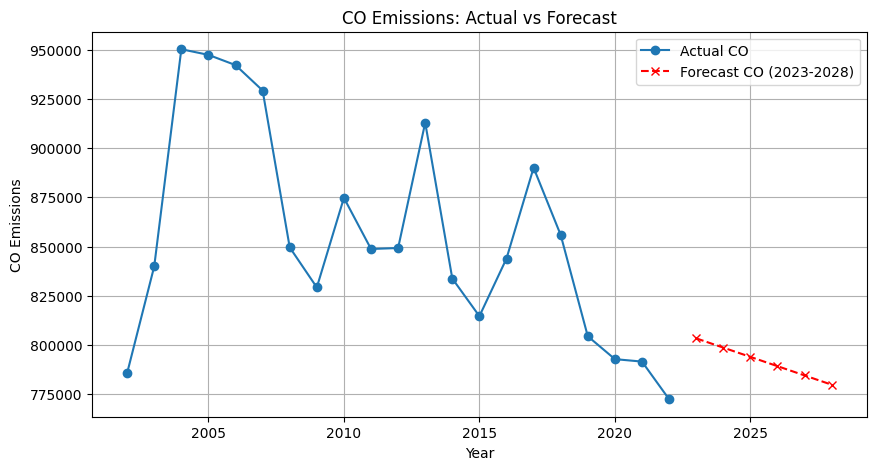

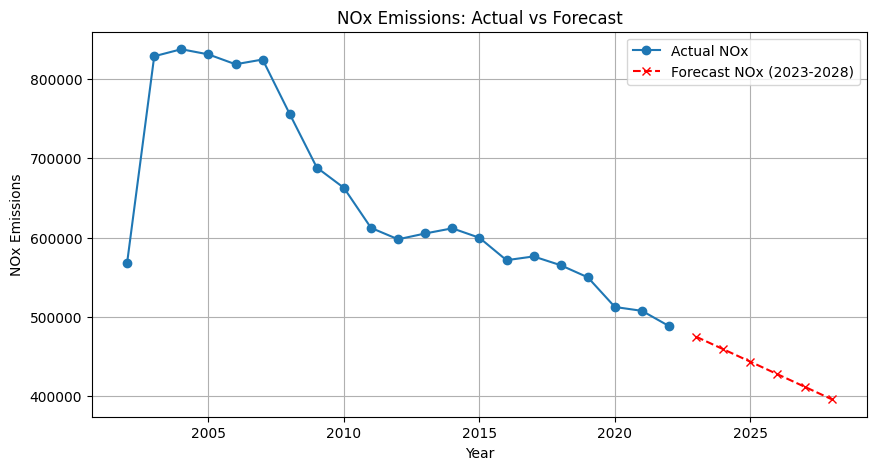

In [ ]:
import matplotlib.pyplot as plt

# Plot CO
plt.figure(figsize=(10,5))
plt.plot(co_df['year'], co_df['emissions'], marker='o', label='Actual CO')
plt.plot(co_forecast['year'], co_forecast['predicted_emissions'], marker='x', linestyle='--', color='red', label='Forecast CO (2023-2028)')
plt.xlabel('Year')
plt.ylabel('CO Emissions')
plt.title('CO Emissions: Actual vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

# Plot NOx
plt.figure(figsize=(10,5))
plt.plot(nox_df['year'], nox_df['emissions'], marker='o', label='Actual NOx')
plt.plot(nox_forecast['year'], nox_forecast['predicted_emissions'], marker='x', linestyle='--', color='red', label='Forecast NOx (2023-2028)')
plt.xlabel('Year')
plt.ylabel('NOx Emissions')
plt.title('NOx Emissions: Actual vs Forecast')
plt.legend()
plt.grid(True)
plt.show()


##Model 2: Rolling Window Linear Regression

This model is just predicting the trendline - however, the emissions practices of 2002-2006 should not have much impact on the emissions from 2022-2026, so we'll narrow the prediction to cover a little more recent window.

In [ ]:
def rolling_forecast(frame, window=7, start_year=2023, end_year=2028):
    # Copy frame to avoid modifying original
    history = frame.copy()

    forecast_years = list(range(start_year, end_year + 1))
    predictions = []

    for year in forecast_years:
        # Select last `window` years
        recent = history.tail(window)
        X = recent[['year']]
        y = recent['emissions']

        # Train linear regression
        model = LinearRegression()
        model.fit(X, y)

        # Predict next year
        pred = model.predict(pd.DataFrame({'year':[year]}))[0]
        predictions.append({'year': year, 'predicted_emissions': pred})

        # Add prediction to history for next iteration
        history = pd.concat([history, pd.DataFrame({'year':[year], 'emissions':[pred]})], ignore_index=True)

    return pd.DataFrame(predictions)

# CO forecast with rolling window
co_rolling_forecast = rolling_forecast(co_df)

# NOx forecast with rolling window
nox_rolling_forecast = rolling_forecast(nox_df)

print(co_rolling_forecast)
print(nox_rolling_forecast)

   year  predicted_emissions
0  2023        753677.691570
1  2024        724486.470541
2  2025        711292.124192
3  2026        699555.109660
4  2027        679687.736194
5  2028        658455.621051
   year  predicted_emissions
0  2023        476070.770017
1  2024        454271.309183
2  2025        435668.162620
3  2026        419107.304725
4  2027        405047.717163
5  2028        385624.908345


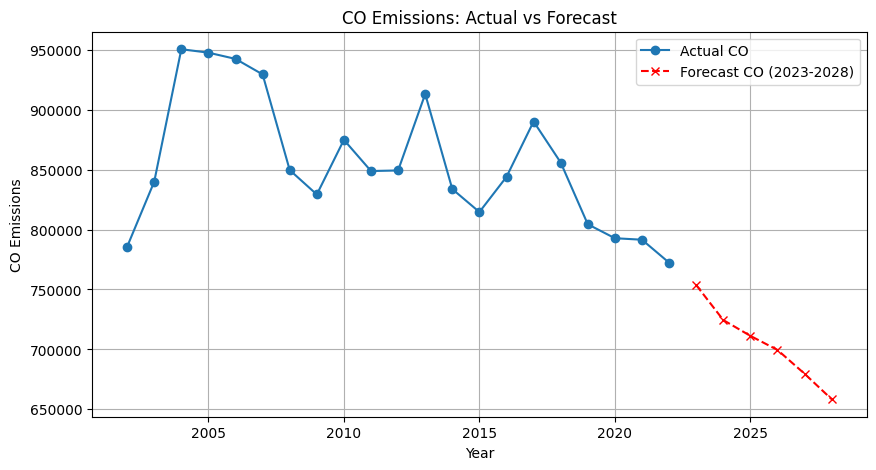

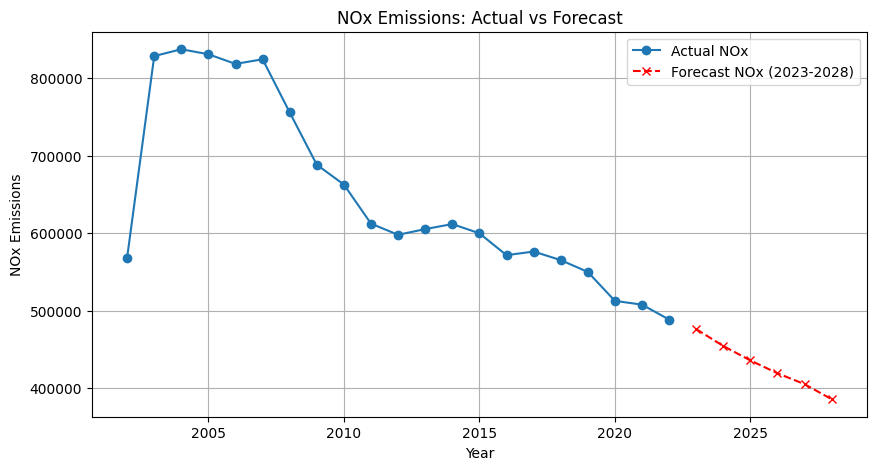

In [ ]:
# Plot CO
plt.figure(figsize=(10,5))
plt.plot(co_df['year'], co_df['emissions'], marker='o', label='Actual CO')
plt.plot(co_rolling_forecast['year'], co_rolling_forecast['predicted_emissions'], marker='x', linestyle='--', color='red', label='Forecast CO (2023-2028)')
plt.xlabel('Year')
plt.ylabel('CO Emissions')
plt.title('CO Emissions: Actual vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

# Plot NOx
plt.figure(figsize=(10,5))
plt.plot(nox_df['year'], nox_df['emissions'], marker='o', label='Actual NOx')
plt.plot(nox_rolling_forecast['year'], nox_rolling_forecast['predicted_emissions'], marker='x', linestyle='--', color='red', label='Forecast NOx (2023-2028)')
plt.xlabel('Year')
plt.ylabel('NOx Emissions')
plt.title('NOx Emissions: Actual vs Forecast')
plt.legend()
plt.grid(True)
plt.show()


##Model 3: Introducing the Carbon Price

In [ ]:
def add_carbon_price_vectorized(frame):
    years = frame['year']
    # Initialize price column with zeros
    carbon_price = np.zeros(len(frame))

    # 2019–2022: 20 + 10*(year-2019)
    mask_2019_2022 = (years >= 2019) & (years <= 2022)
    carbon_price[mask_2019_2022] = 20 + 10 * (years[mask_2019_2022] - 2019)

    # 2023+: 50 + 15*(year-2022)
    mask_2023_plus = years >= 2023
    carbon_price[mask_2023_plus] = 50 + 15 * (years[mask_2023_plus] - 2022)

    frame['carbon_price'] = carbon_price
    return frame

# Apply to both CO and NOx
co_df = add_carbon_price_vectorized(co_df)
nox_df = add_carbon_price_vectorized(nox_df)

print(co_df)
print(nox_df)

    year      emissions  carbon_price
0   2002  785614.265000           0.0
1   2003  839905.977000           0.0
2   2004  950352.042000           0.0
3   2005  947485.253000           0.0
4   2006  942279.048000           0.0
5   2007  929354.162000           0.0
6   2008  849565.873610           0.0
7   2009  829202.141990           0.0
8   2010  874761.351900           0.0
9   2011  848754.120200           0.0
10  2012  849241.625800           0.0
11  2013  912996.808400           0.0
12  2014  833712.782200           0.0
13  2015  814571.056310           0.0
14  2016  843894.548717           0.0
15  2017  890069.931959           0.0
16  2018  855868.347526           0.0
17  2019  804354.788279          20.0
18  2020  792726.996112          30.0
19  2021  791479.298281          40.0
20  2022  772339.048759          50.0
    year      emissions  carbon_price
0   2002  568325.266880           0.0
1   2003  828369.820688           0.0
2   2004  837227.818500           0.0
3   2005  83

Let's train the model and see what happens with a new feature.

In [ ]:
def rolling_forecast_with_feature(frame, window=7, start_year=2023, end_year=2028):
    history = frame.copy()
    forecast_years = list(range(start_year, end_year + 1))
    predictions = []

    for year in forecast_years:
        # Select last `window` years
        recent = history.tail(window)
        X = recent[['year', 'carbon_price']]
        y = recent['emissions']

        # Train linear regression
        model = LinearRegression()
        model.fit(X, y)

        # Determine carbon price for the prediction year
        if year <= 2022:
            carbon_price = 20 + 10 * (year - 2019) if year >= 2019 else 0
        else:
            carbon_price = 50 + 15 * (year - 2022)

        # Predict next year
        pred = model.predict(pd.DataFrame({'year':[year], 'carbon_price':[carbon_price]}))[0]
        predictions.append({'year': year, 'predicted_emissions': pred})

        # Add prediction to history for next iteration
        history = pd.concat([history, pd.DataFrame({'year':[year], 'emissions':[pred], 'carbon_price':[carbon_price]})], ignore_index=True)

    return pd.DataFrame(predictions)

# CO forecast
co_rolling_forecast = rolling_forecast_with_feature(co_df)

# NOx forecast
nox_rolling_forecast = rolling_forecast_with_feature(nox_df)

print("CO forecast:\n", co_rolling_forecast)
print("\nNOx forecast:\n", nox_rolling_forecast)

CO forecast:
    year  predicted_emissions
0  2023        734257.786840
1  2024        709797.513767
2  2025        676758.231654
3  2026        643288.071249
4  2027        611191.736824
5  2028        580103.565993

NOx forecast:
    year  predicted_emissions
0  2023        465496.322442
1  2024        444843.180595
2  2025        424338.881054
3  2026        403631.675560
4  2027        381029.715511
5  2028        360318.394959


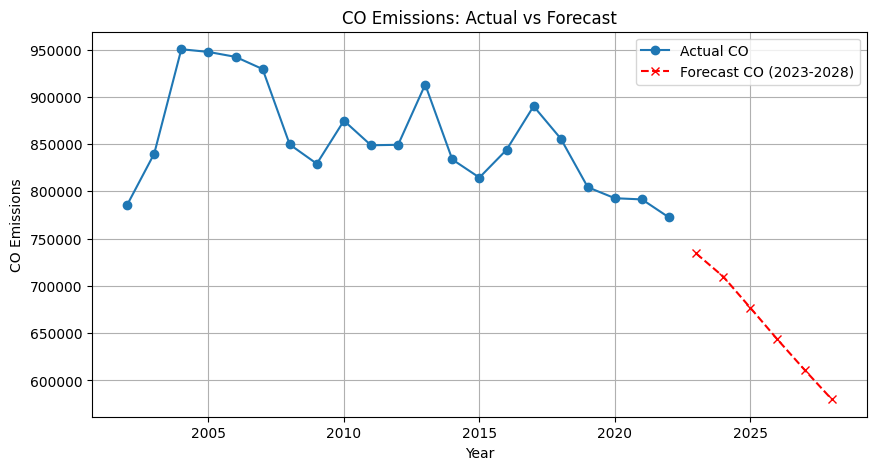

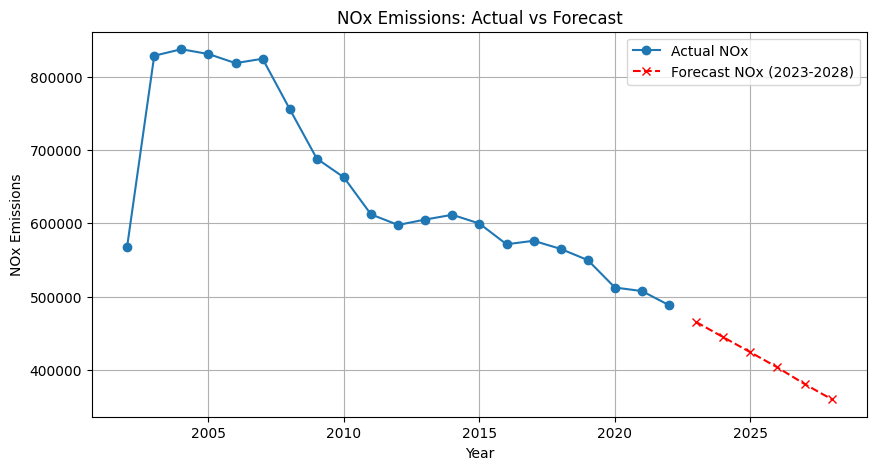

In [ ]:
# Plot CO
plt.figure(figsize=(10,5))
plt.plot(co_df['year'], co_df['emissions'], marker='o', label='Actual CO')
plt.plot(co_rolling_forecast['year'], co_rolling_forecast['predicted_emissions'], marker='x', linestyle='--', color='red', label='Forecast CO (2023-2028)')
plt.xlabel('Year')
plt.ylabel('CO Emissions')
plt.title('CO Emissions: Actual vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

# Plot NOx
plt.figure(figsize=(10,5))
plt.plot(nox_df['year'], nox_df['emissions'], marker='o', label='Actual NOx')
plt.plot(nox_rolling_forecast['year'], nox_rolling_forecast['predicted_emissions'], marker='x', linestyle='--', color='red', label='Forecast NOx (2023-2028)')
plt.xlabel('Year')
plt.ylabel('NOx Emissions')
plt.title('NOx Emissions: Actual vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Rolling evaluation WITHOUT carbon price
def rolling_evaluate(frame, window=7):
    history = frame.copy()
    actuals = []
    preds = []

    for i in range(window, len(frame)):
        recent = history.iloc[i-window:i]
        X = recent[['year']]  # <-- only year
        y = recent['emissions']

        model = LinearRegression()
        model.fit(X, y)

        X_pred = frame.iloc[i][['year']].to_frame().T
        pred = model.predict(X_pred)[0]

        preds.append(pred)
        actuals.append(frame.iloc[i]['emissions'])

    mae = mean_absolute_error(actuals, preds)
    rmse = np.sqrt(mean_squared_error(actuals, preds))
    return {'MAE': mae, 'RMSE': rmse, 'predictions': preds, 'actuals': actuals}

# Rolling evaluation WITH carbon price
def rolling_evaluate_with_carbon(frame, window=7):
    history = frame.copy()
    actuals = []
    preds = []

    for i in range(window, len(frame)):
        recent = history.iloc[i-window:i]
        X = recent[['year','carbon_price']]  # include carbon price
        y = recent['emissions']

        model = LinearRegression()
        model.fit(X, y)

        X_pred = frame.iloc[i][['year','carbon_price']].to_frame().T
        pred = model.predict(X_pred)[0]

        preds.append(pred)
        actuals.append(frame.iloc[i]['emissions'])

    mae = mean_absolute_error(actuals, preds)
    rmse = np.sqrt(mean_squared_error(actuals, preds))
    return {'MAE': mae, 'RMSE': rmse, 'predictions': preds, 'actuals': actuals}


# Rolling evaluation of CO with and without carbon price
co_metrics = rolling_evaluate(co_df)
co_metrics_carbon = rolling_evaluate_with_carbon(co_df)

print("CO metrics (without carbon price): MAE =", co_metrics['MAE'], "RMSE =", co_metrics['RMSE'])
print("CO metrics (with carbon price): MAE =", co_metrics_carbon['MAE'], "RMSE =", co_metrics_carbon['RMSE'])

# Rolling evaluation of NOx with and without carbon price

nox_metrics = rolling_evaluate(nox_df)
nox_metrics_carbon = rolling_evaluate_with_carbon(nox_df)

print("NOx metrics (without carbon price): MAE =", nox_metrics['MAE'], "RMSE =", nox_metrics['RMSE'])
print("NOx metrics (with carbon price): MAE =", nox_metrics_carbon['MAE'], "RMSE =", nox_metrics_carbon['RMSE'])

CO metrics (without carbon price): MAE = 39990.51934070361 RMSE = 51388.61693474472
CO metrics (with carbon price): MAE = 38727.665745789585 RMSE = 50944.26124655783
NOx metrics (without carbon price): MAE = 38109.27040745887 RMSE = 58055.16794522857
NOx metrics (with carbon price): MAE = 37450.06317565964 RMSE = 57885.122694561374


What's interesting is that the errors *did* end up decreasing when the carbon price feature was added, though not by much.

##Model 4: Adding lagged features (t-1, t-2, etc.)

In [ ]:
def add_lag_features(df, max_lag=3):
    df = df.sort_values('year').reset_index(drop=True)
    for lag in range(1, max_lag+1):
        df[f'emissions_lag{lag}'] = df['emissions'].shift(lag)
    return df

# Apply to both CO and NOx
co_df = add_lag_features(co_df, max_lag=3)
nox_df = add_lag_features(nox_df, max_lag=3)

print(co_df)
print(nox_df)


    year      emissions  carbon_price  emissions_lag1  emissions_lag2  \
0   2002  785614.265000           0.0             NaN             NaN   
1   2003  839905.977000           0.0   785614.265000             NaN   
2   2004  950352.042000           0.0   839905.977000   785614.265000   
3   2005  947485.253000           0.0   950352.042000   839905.977000   
4   2006  942279.048000           0.0   947485.253000   950352.042000   
5   2007  929354.162000           0.0   942279.048000   947485.253000   
6   2008  849565.873610           0.0   929354.162000   942279.048000   
7   2009  829202.141990           0.0   849565.873610   929354.162000   
8   2010  874761.351900           0.0   829202.141990   849565.873610   
9   2011  848754.120200           0.0   874761.351900   829202.141990   
10  2012  849241.625800           0.0   848754.120200   874761.351900   
11  2013  912996.808400           0.0   849241.625800   848754.120200   
12  2014  833712.782200           0.0   912996.8084

In [ ]:
#Predicting again with the new features
def rolling_forecast_with_lags(frame, max_lag=3, window=7, start_year=2023, end_year=2028):
    frame = frame.sort_values('year').reset_index(drop=True)
    history = frame.copy()
    forecast_years = list(range(start_year, end_year + 1))
    predictions = []

    lag_cols = [f'emissions_lag{lag}' for lag in range(1, max_lag+1)]

    for year in forecast_years:
        # Select last `window` years that have lag features
        recent = history.tail(window)
        X = recent[['year', 'carbon_price'] + lag_cols]
        y = recent['emissions']

        # Train linear regression
        model = LinearRegression()
        model.fit(X, y)

        # Build feature row for prediction year
        # Get previous emissions for lag features
        lag_values = history['emissions'].tail(max_lag).tolist()
        # Pad with NaN if not enough history
        lag_values = [0]*(max_lag - len(lag_values)) + lag_values

        # Determine carbon price for the prediction year
        if year <= 2022:
            carbon_price = 20 + 10 * (year - 2019) if year >= 2019 else 0
        else:
            carbon_price = 50 + 15 * (year - 2022)

        X_pred = pd.DataFrame([{'year': year, 'carbon_price': carbon_price, **{f'emissions_lag{i+1}': lag_values[i] for i in range(max_lag)}}])

        # Predict next year
        pred = model.predict(X_pred)[0]
        predictions.append({'year': year, 'predicted_emissions': pred})

        # Add prediction to history for next iteration
        new_row = {'year': year, 'emissions': pred, 'carbon_price': carbon_price}
        new_row.update({f'emissions_lag{i+1}': lag_values[i] for i in range(max_lag)})
        history = pd.concat([history, pd.DataFrame([new_row])], ignore_index=True)

    return pd.DataFrame(predictions)

# CO forecast
co_rolling_forecast = rolling_forecast_with_lags(co_df)

# NOx forecast
nox_rolling_forecast = rolling_forecast_with_lags(nox_df)

print("CO forecast with lags:\n", co_rolling_forecast)
print("\nNOx forecast with lags:\n", nox_rolling_forecast)

CO forecast with lags:
    year  predicted_emissions
0  2023        724631.442907
1  2024        692564.887860
2  2025        688791.587576
3  2026        692007.336040
4  2027        663377.996419
5  2028        615860.201003

NOx forecast with lags:
    year  predicted_emissions
0  2023        510216.892538
1  2024        439603.941284
2  2025        486088.150687
3  2026        371522.128062
4  2027        500995.192123
5  2028        274191.811589


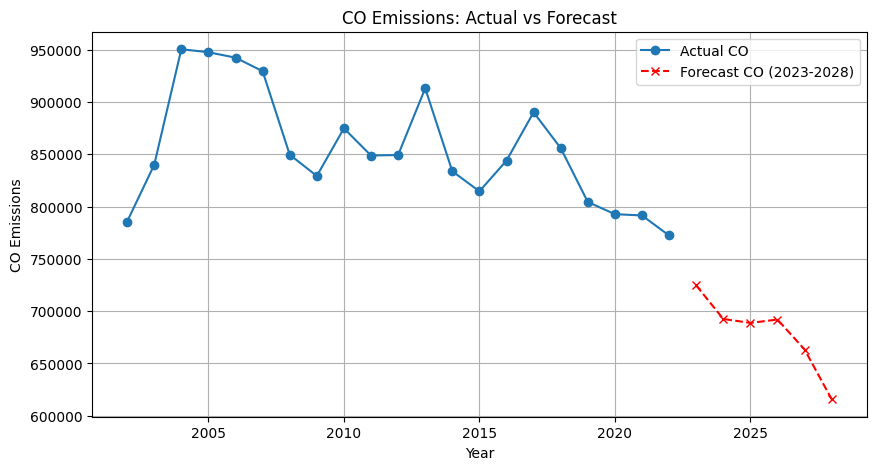

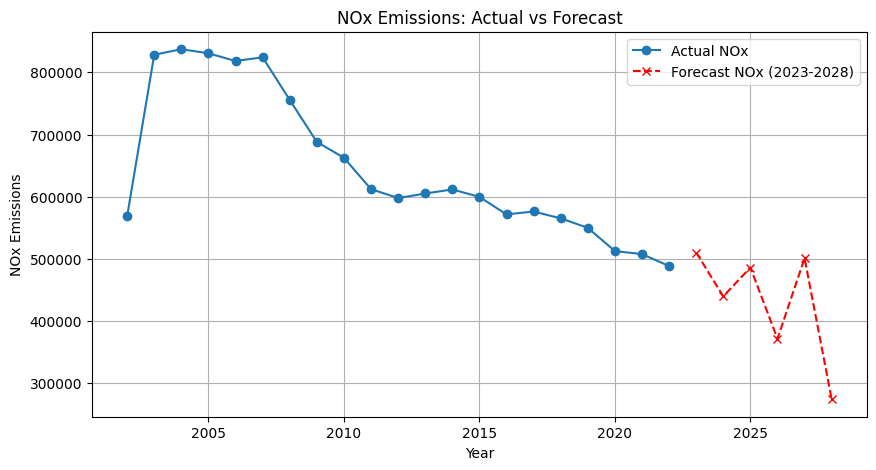

In [ ]:
# Plot CO
plt.figure(figsize=(10,5))
plt.plot(co_df['year'], co_df['emissions'], marker='o', label='Actual CO')
plt.plot(co_rolling_forecast['year'], co_rolling_forecast['predicted_emissions'], marker='x', linestyle='--', color='red', label='Forecast CO (2023-2028)')
plt.xlabel('Year')
plt.ylabel('CO Emissions')
plt.title('CO Emissions: Actual vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

# Plot NOx
plt.figure(figsize=(10,5))
plt.plot(nox_df['year'], nox_df['emissions'], marker='o', label='Actual NOx')
plt.plot(nox_rolling_forecast['year'], nox_rolling_forecast['predicted_emissions'], marker='x', linestyle='--', color='red', label='Forecast NOx (2023-2028)')
plt.xlabel('Year')
plt.ylabel('NOx Emissions')
plt.title('NOx Emissions: Actual vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

##Model 5: Examining one sector (211)

The carbon pricing policy is a policy that greatly affects the oil and gas industry. The behaviors of fossil fuel consumption will vary from company to company. Perhaps we can get a more predictable response if we narrow our data to the oil and gas sector.

In [ ]:
# Keep only NAICS 211
df_211 = filtered_df[filtered_df['naics'].str.startswith('211')]

# Aggregate total emissions by year and substance
agg_211 = df_211.groupby(['year', 'substance'])['emissions'].sum().reset_index()

# Split into CO and NOx
co_211 = agg_211[agg_211['substance'] == 'Carbon monoxide'][['year', 'emissions']]
nox_211 = agg_211[agg_211['substance'] == 'Nitrogen oxides (expressed as nitrogen dioxide)'][['year', 'emissions']]



2002 is basically unusable - there's mass amounts of underreporting; perhaps this industry wasn't audited to report as much at that time? Either way, we're getting rid of it.

In [ ]:
# Remove 2002
co_211 = co_211[co_211['year'] != 2002].reset_index(drop=True)
nox_211 = nox_211[nox_211['year'] != 2002].reset_index(drop=True)


Let's add lagged features again.

In [ ]:
def add_lag_features(df, max_lag=3):
    df = df.sort_values('year').reset_index(drop=True)
    for lag in range(1, max_lag+1):
        df[f'emissions_lag{lag}'] = df['emissions'].shift(lag)
    return df

# Apply to both CO and NOx
co_211 = add_lag_features(co_211, max_lag=3)
nox_211 = add_lag_features(nox_211, max_lag=3)

print(co_211)
print(nox_211)

    year      emissions  emissions_lag1  emissions_lag2  emissions_lag3
0   2003  170405.158000             NaN             NaN             NaN
1   2004  178033.852000   170405.158000             NaN             NaN
2   2005  172552.098000   178033.852000   170405.158000             NaN
3   2006  160519.207000   172552.098000   178033.852000   170405.158000
4   2007  178395.642000   160519.207000   172552.098000   178033.852000
5   2008  177849.088760   178395.642000   160519.207000   172552.098000
6   2009  176669.708920   177849.088760   178395.642000   160519.207000
7   2010  171982.961600   176669.708920   177849.088760   178395.642000
8   2011  158452.276200   171982.961600   176669.708920   177849.088760
9   2012  164339.122800   158452.276200   171982.961600   176669.708920
10  2013  202639.534000   164339.122800   158452.276200   171982.961600
11  2014  198408.523200   202639.534000   164339.122800   158452.276200
12  2015  184051.151810   198408.523200   202639.534000   164339

In [ ]:
#Predicting again with the new features
def rolling_forecast_with_lags(frame, max_lag=3, window=7, start_year=2023, end_year=2028):
    frame = frame.sort_values('year').reset_index(drop=True)
    history = frame.copy()
    forecast_years = list(range(start_year, end_year + 1))
    predictions = []

    lag_cols = [f'emissions_lag{lag}' for lag in range(1, max_lag+1)]

    for year in forecast_years:
        # Select last `window` years that have lag features
        recent = history.tail(window)
        X = recent[['year'] + lag_cols]
        y = recent['emissions']

        # Train linear regression
        model = LinearRegression()
        model.fit(X, y)

        # Build feature row for prediction year
        # Get previous emissions for lag features
        lag_values = history['emissions'].tail(max_lag).tolist()
        # Pad with NaN if not enough history
        lag_values = [0]*(max_lag - len(lag_values)) + lag_values

        X_pred = pd.DataFrame([{'year': year, **{f'emissions_lag{i+1}': lag_values[i] for i in range(max_lag)}}])

        # Predict next year
        pred = model.predict(X_pred)[0]
        predictions.append({'year': year, 'predicted_emissions': pred})

        # Add prediction to history for next iteration
        new_row = {'year': year, 'emissions': pred}
        new_row.update({f'emissions_lag{i+1}': lag_values[i] for i in range(max_lag)})
        history = pd.concat([history, pd.DataFrame([new_row])], ignore_index=True)

    return pd.DataFrame(predictions)

# CO forecast
co_rolling_forecast = rolling_forecast_with_lags(co_211)

# NOx forecast
nox_rolling_forecast = rolling_forecast_with_lags(nox_211)

print("CO forecast with lags:\n", co_rolling_forecast)
print("\nNOx forecast with lags:\n", nox_rolling_forecast)

CO forecast with lags:
    year  predicted_emissions
0  2023        182025.633193
1  2024        182643.264940
2  2025        174021.141052
3  2026        183077.618911
4  2027        183593.804924
5  2028        189014.268848

NOx forecast with lags:
    year  predicted_emissions
0  2023        234702.885341
1  2024        231387.008210
2  2025        224792.788513
3  2026        224474.274780
4  2027        219795.197692
5  2028        218368.556802


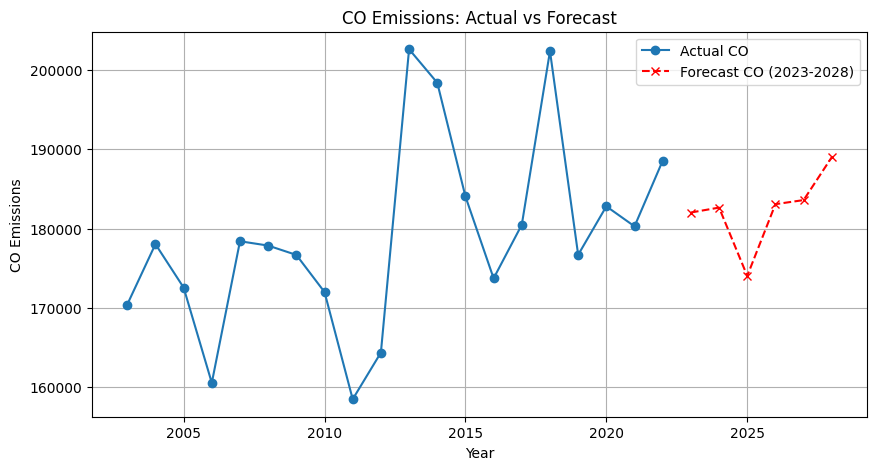

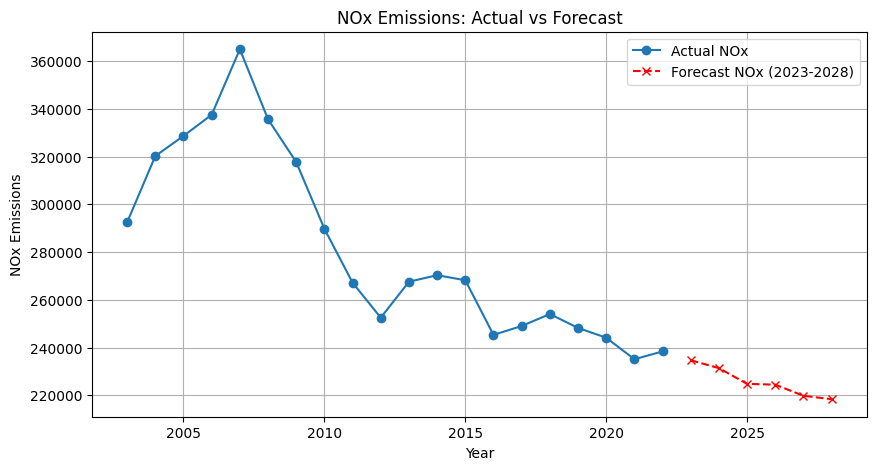

In [ ]:
# Plot CO
plt.figure(figsize=(10,5))
plt.plot(co_211['year'], co_211['emissions'], marker='o', label='Actual CO')
plt.plot(co_rolling_forecast['year'], co_rolling_forecast['predicted_emissions'], marker='x', linestyle='--', color='red', label='Forecast CO (2023-2028)')
plt.xlabel('Year')
plt.ylabel('CO Emissions')
plt.title('CO Emissions: Actual vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

# Plot NOx
plt.figure(figsize=(10,5))
plt.plot(nox_211['year'], nox_211['emissions'], marker='o', label='Actual NOx')
plt.plot(nox_rolling_forecast['year'], nox_rolling_forecast['predicted_emissions'], marker='x', linestyle='--', color='red', label='Forecast NOx (2023-2028)')
plt.xlabel('Year')
plt.ylabel('NOx Emissions')
plt.title('NOx Emissions: Actual vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

The NOx prediction seems okay, but with the rapid fluctuations in this industry's carbon monoxide output, it seems like emissions alone won't be a strong way to predict future emissions. What might we need? More features.

In [ ]:
# Filter out 2002 and keep only NAICS 211
df_211 = merged_df[(merged_df['naics'].astype(str).str.startswith('211')) & (merged_df['year'] != 2002)]

# Aggregate for Carbon monoxide
co_agg = df_211[df_211['substance'] == 'Carbon monoxide'].groupby('year').agg({
    'gdp': 'sum',
    'pop': 'sum'  # Keep column name as 'pop'
}).reset_index().rename(columns={'gdp': 'GDP_211'})

# Aggregate for Nitrogen oxides
nox_agg = df_211[df_211['substance'] == 'Nitrogen oxides (expressed as nitrogen dioxide)']\
    .groupby('year').agg({'gdp': 'sum', 'pop': 'sum'}).reset_index().rename(columns={'gdp': 'GDP_211'})



In [ ]:
# Merge the aggregated GDP into the CO and NOx dataframes
co_211 = co_211.merge(co_agg, on='year', how='left')
nox_211 = nox_211.merge(nox_agg, on='year', how='left')

# Sanity check
print("CO 211 DataFrame:\n", co_211)
print("\nNOx 211 DataFrame:\n", nox_211)


CO 211 DataFrame:
     year      emissions  emissions_lag1  emissions_lag2  emissions_lag3  \
0   2003  170405.158000             NaN             NaN             NaN   
1   2004  178033.852000   170405.158000             NaN             NaN   
2   2005  172552.098000   178033.852000   170405.158000             NaN   
3   2006  160519.207000   172552.098000   178033.852000   170405.158000   
4   2007  178395.642000   160519.207000   172552.098000   178033.852000   
5   2008  177849.088760   178395.642000   160519.207000   172552.098000   
6   2009  176669.708920   177849.088760   178395.642000   160519.207000   
7   2010  171982.961600   176669.708920   177849.088760   178395.642000   
8   2011  158452.276200   171982.961600   176669.708920   177849.088760   
9   2012  164339.122800   158452.276200   171982.961600   176669.708920   
10  2013  202639.534000   164339.122800   158452.276200   171982.961600   
11  2014  198408.523200   202639.534000   164339.122800   158452.276200   
12  20

In [ ]:
# Sort by year just in case
co_211 = co_211.sort_values('year').reset_index(drop=True)
nox_211 = nox_211.sort_values('year').reset_index(drop=True)

# Add 1-year lag for GDP_211 and pop
co_211['GDP_211_lag1'] = co_211['GDP_211'].shift(1)
co_211['pop_lag1'] = co_211['pop'].shift(1)

nox_211['GDP_211_lag1'] = nox_211['GDP_211'].shift(1)
nox_211['pop_lag1'] = nox_211['pop'].shift(1)

# Optionally fill first row NaNs with 0 or leave as NaN
co_211[['GDP_211_lag1', 'pop_lag1']] = co_211[['GDP_211_lag1', 'pop_lag1']].fillna(0)
nox_211[['GDP_211_lag1', 'pop_lag1']] = nox_211[['GDP_211_lag1', 'pop_lag1']].fillna(0)

# Sanity check
print(co_211.head())
print(nox_211.head())

   year   emissions  emissions_lag1  emissions_lag2  emissions_lag3  GDP_211  \
0  2003  170405.158             NaN             NaN             NaN  44976.5   
1  2004  178033.852      170405.158             NaN             NaN  46288.3   
2  2005  172552.098      178033.852      170405.158             NaN  47018.0   
3  2006  160519.207      172552.098      178033.852      170405.158  48653.4   
4  2007  178395.642      160519.207      172552.098      178033.852  48965.9   

        pop  GDP_211_lag1    pop_lag1  
0  22046469           0.0         0.0  
1  22313154       44976.5  22046469.0  
2  23744809       46288.3  22313154.0  
3  31656885       47018.0  23744809.0  
4  24249398       48653.4  31656885.0  
   year    emissions  emissions_lag1  emissions_lag2  emissions_lag3  GDP_211  \
0  2003  292438.3590             NaN             NaN             NaN  44989.2   
1  2004  320212.3925     292438.3590             NaN             NaN  46288.3   
2  2005  328630.4550     320212.3925

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression

def rolling_forecast_existing_lags(df, features, target='emissions', window=7, start_year=2023, end_year=2028):
    df = df.sort_values('year').reset_index(drop=True)
    history = df.copy()
    forecast_years = list(range(start_year, end_year + 1))
    predictions = []

    for year in forecast_years:
        # Use the last 'window' rows for training
        recent = history.tail(window)
        X = recent[features]
        y = recent[target]

        # Train linear regression
        model = LinearRegression()
        model.fit(X, y)

        # Prepare next year's feature row
        next_row = {}
        for f in features:
            if f.endswith('_lag1') or f.endswith('_lag2') or f.endswith('_lag3'):
                # take the previous year's value of the corresponding column
                base_col = f.replace('_lag1','').replace('_lag2','').replace('_lag3','')
                next_row[f] = history[base_col].iloc[-1]
            else:
                # current year values from last row
                next_row[f] = history[f].iloc[-1]

        X_pred = pd.DataFrame([next_row])

        # Predict
        pred = model.predict(X_pred)[0]
        predictions.append({'year': year, 'predicted_emissions': pred})

        # Append new row to history for next iteration
        new_row = {'year': year, target: pred}
        for f in features:
            new_row[f] = X_pred[f].iloc[0]
        history = pd.concat([history, pd.DataFrame([new_row])], ignore_index=True)

    return pd.DataFrame(predictions)

# Define features you want to use
features = ['emissions_lag1', 'emissions_lag2', 'emissions_lag3', 'GDP_211', 'pop', 'GDP_211_lag1', 'pop_lag1']

# Run forecast
co_forecast = rolling_forecast_existing_lags(co_211, features)
nox_forecast = rolling_forecast_existing_lags(nox_211, features)

print(co_forecast)
print(nox_forecast)


   year  predicted_emissions
0  2023        181693.561978
1  2024        195226.935552
2  2025        168587.485002
3  2026        221025.284176
4  2027        117805.333108
5  2028        320986.215341
   year  predicted_emissions
0  2023        238243.099252
1  2024        238309.644993
2  2025        238279.542618
3  2026        238293.159613
4  2027        238286.999881
5  2028        238289.786274


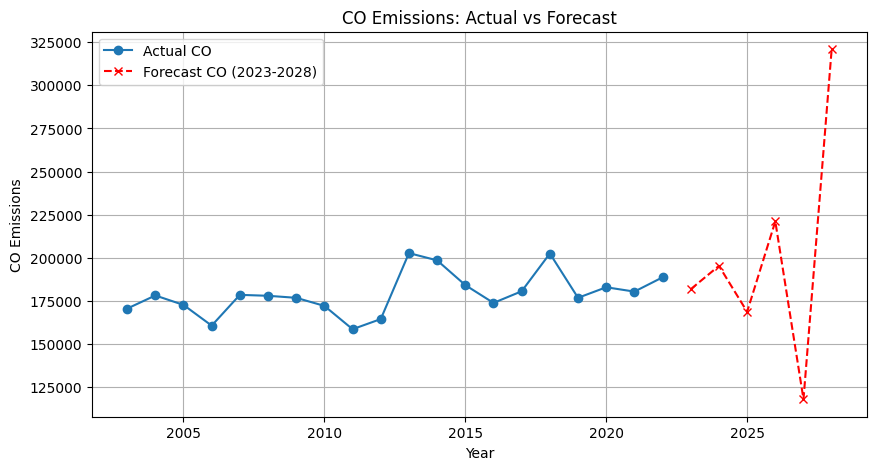

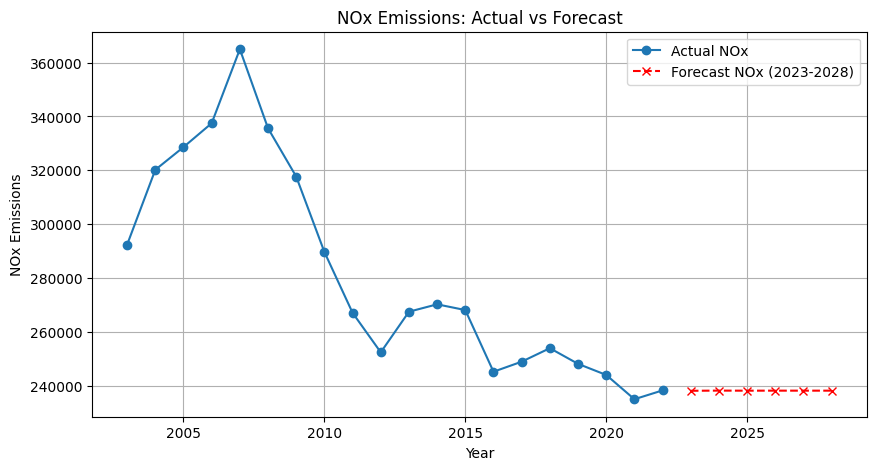

In [ ]:
# Plot CO
plt.figure(figsize=(10,5))
plt.plot(co_211['year'], co_211['emissions'], marker='o', label='Actual CO')
plt.plot(co_forecast['year'], co_forecast['predicted_emissions'], marker='x', linestyle='--', color='red', label='Forecast CO (2023-2028)')
plt.xlabel('Year')
plt.ylabel('CO Emissions')
plt.title('CO Emissions: Actual vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

# Plot NOx
plt.figure(figsize=(10,5))
plt.plot(nox_211['year'], nox_211['emissions'], marker='o', label='Actual NOx')
plt.plot(nox_forecast['year'], nox_forecast['predicted_emissions'], marker='x', linestyle='--', color='red', label='Forecast NOx (2023-2028)')
plt.xlabel('Year')
plt.ylabel('NOx Emissions')
plt.title('NOx Emissions: Actual vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

We're running into problems:


*   Our dataset has too many features compared to rows. We have 20 rows and 9 features. Our model is playing it safe and not fluctuating its predictions.
*   Our features aren't scaled appropriately. The raw figures of each value are causing domination (Population is in the tens of millions, GDP is set to millions, and emissions are in the hundred thousands.)



#Overall Summary


###Limitations, Considerations, and Constraints

The primary challenge is the **limited number of time points** (20–21 years). Simple models fail to capture nuanced trends, while complex models overfit heavily. The models we considered, but ultimately did not pursue, include:

**XGBoost**: Capable of modeling nonlinear relationships and interactions with external factors (population, energy, GDP, carbon pricing). However, with so few annual data points, it would overfit, producing predictions that largely reflect noise.

**Hierarchical approach (Multi-level Random Forest, LightGBM)**: Could leverage company-, sector-, and province-level groupings to partially pool information and improve inference across sparse time series. Unfortunately, sparse observations and inconsistent reporting across companies would result in noise-driven predictions.

**A panel approach (using any of the models above)**: Can account for both cross-sectional and time-series variation, controlling for unobserved heterogeneity. Yet with only ~20 years of data and spotty reporting, the estimates are unstable and prone to overfitting, providing little reliable predictive power.

Regularization techniques (e.g., L1/Lasso, L2/Ridge) can help prevent overfitting by penalizing extreme coefficient values or model complexity. However, in this dataset, even strong regularization cannot fully overcome the fundamental issue: there are far more features than meaningful data points. As a result, complex models still mostly capture noise rather than true signal, limiting the reliability of predictions.

This project illustrates a concept emphasized earlier in the course: the relationship between data quality and problem-solving ability. Complex problems require high-quality data and sufficient volume to support complex models. With our current dataset, only simple prediction tasks—forecasting future emissions values without inferring causation—are feasible. Unfortunately, this is a complex problem, involving dozens of factors that far outnumber the available annual reports. Solving it would require not only more data, but also higher-resolution emissions reporting (quarterly, monthly, weekly, or ideally daily). Capturing trends over shorter periods could help identify patterns that persist over longer time frames, improving predictive reliability.

Additionally, identifying causal effects from economic factors would require advanced domain expertise, at the level of post-graduate or doctoral training. Combining higher-frequency, higher-quality data with such subject-matter expertise would greatly improve the feasibility of this project going forward.